In [16]:
library(ape)
library(tidyverse)
library(glue)
library(dplyr)
library(phytools)
library(nlme)
library(lme4)
library(lmerTest)
library(lmtest)
library(glmmTMB) 
library(LaplacesDemon) # documentation: https://rdrr.io/cran/phyr/man/pglmm.html
library(ggplot2)
library(ggpubr)
library(rstatix)
library(DHARMa)
library(betareg)
source("../../../code/feature_computation/utils.R")
library(pbmcapply)
library(vegan)
library(comprehenr)
library(picante)
library(caper)

In [17]:
remotes::install_github("wzmli/phyloglmm/pkg@refactor")
library(phyloglmm)

Skipping install of 'phyloglmm' from a github remote, the SHA1 (c94368f2) has not changed since last install.
  Use `force = TRUE` to force installation



In [57]:
# process data
do_weighted = FALSE
include_metadata = TRUE
include_ms = TRUE
only_prevalent = FALSE
include_flw_shape = TRUE
allow_poly_var = TRUE
predictor = "is_polyploid"
#predictor = "ploidy_age"

weighted_str = "unweighted" 
if (do_weighted)
{
    weighted_str = "weighted" 
}

features_of_interest = c("standardized_d", 
                         "standardized_partner.diversity", 
                         "standardized_normalised.degree", 
                         "standardized_weighted.betweenness", 
                         "standardized_weighted.closeness", 
                         "standardized_hubbiness_score")

metadata_features = c("network_index", "network_size", "has_ploidy_variablity")
meta_str = ""
if (include_metadata)
{
    metadata_features = c(metadata_features, c("Lifeform", "flw_color"))#, "flw_size_mean")) # try to remove flower shape - it is biased towards our question (pollination restrcitive / unrestrictive)
    meta_str = "_with_metadata"
}

ms_str = ""
if (include_ms)
{
    ms_str = "_with_mating_system"
    metadata_features = c(metadata_features, ("mating_system"))
}
only_prevalent_str = ""
if (only_prevalent)
{
    only_prevalent_str = "_only_prevalent"
}
include_flw_shape_str = ""
if (include_flw_shape)
    {
    include_flw_shape_str = "_w_flw_shape"
    metadata_features = c(metadata_features, ("flw_shape"))
    }


random_vars = c("network_index")

data_path <- glue("../../../data/statistical_analysis/species_level/processed_features_with_ploidy_classification_on_{weighted_str}_networks{only_prevalent_str}.csv")
pair_data_path = glue("../../../data/statistical_analysis/species_level/pair_data_on_{weighted_str}_networks.csv")
tree_path <- glue("../../../data/statistical_analysis/species_level/species_tree_on_{weighted_str}_networks.nwk")
pgls_res_path = glue("../../../data/statistical_analysis/species_level/pgls_res_on_{weighted_str}_networks{meta_str}{ms_str}{include_flw_shape_str}{only_prevalent_str}_predictor_{predictor}.csv")
glmm_res_path = glue("../../../data/statistical_analysis/species_level/glmm_res_on_{weighted_str}_networks{meta_str}{ms_str}{include_flw_shape_str}{only_prevalent_str}_predictor_{predictor}.csv")
pglmm_res_path = glue("../../../data/statistical_analysis/species_level/phylogenetic_glmm_res_on_{weighted_str}{meta_str}{ms_str}{include_flw_shape_str}{only_prevalent_str}_predictor_{predictor}.csv")
res_pair_path = glue("../../../data/statistical_analysis/species_level/pair_test_results_on_{weighted_str}_networks{meta_str}{ms_str}{include_flw_shape_str}{only_prevalent_str}_predictor_{predictor}.csv")

In [58]:
data <- read.csv(data_path)
data <- drop_na(data, any_of(c(c(predictor), features_of_interest,metadata_features)))
if (!allow_poly_var)
    {
    data = data[data$has_ploidy_variablity == 'False',]
    }
for (c in metadata_features)
    {
    data <- subset(data, data[c] != "")
    }


data$sample_id <- factor(data$sample_id)
data[["sample_id_numeric"]] <- as.numeric(data$sample_id)
rownames(data) <- data$sample_id

net_max = max(data$network_size)
min_net = min(data$network_size) 
data$network_size = (net_max-data$network_size)/(net_max-min_net)

data$flw_size_mean = as.numeric(data$flw_size_mean)
size_max = max(data$flw_size_mean)
size_min = min(data$flw_size_mean) 
data$flw_size_mean = (size_max-data$flw_size_mean)/(size_max-size_min)


character_columns <- sapply(data, is.character)
# Convert character columns to factors
data[, character_columns] <- lapply(data[, character_columns], as.factor)
# Convert factors to integers
data[, character_columns] <- lapply(data[, character_columns], as.integer)
print(paste("# samples for analysis = ", nrow(data)))

[1] "# samples for analysis =  2525"


In [59]:
# metadata_features = c("network_index", "network_size", "has_ploidy_variablity")
# pglmm_res_path = glue("../../../data/statistical_analysis/species_level/phylogenetic_glmm_res_on_{weighted_str}{meta_str}{ms_str}{include_flw_shape_str}{only_prevalent_str}_predictor_{predictor}_only_samples_with_metadata.csv")

In [60]:
unrooted_tree <- read.tree(tree_path)
tree <- drop.tip(unrooted_tree,unrooted_tree$tip.label[-match(rownames(data), unrooted_tree$tip.label)])
tree <- multi2di(tree)
tree <- makeNodeLabel(tree, method = "number", prefix = "Node")
print(paste("# tips in tree = ", length(tree$tip)))

[1] "# tips in tree =  2525"


In [61]:
round_df <- function(df, digits = 5) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

# perlimiary tests for phylogenetic signal in polyploidy trait

In [ ]:
# perlimiary test of association of polyploidy with phylogenetic signal
# pagel's lambda
is_polyploid <- data %>% arrange(is_polyploid) %>% pull(is_polyploid, sample_id)
is_polyploid <- as.matrix(is_polyploid[order(match(is_polyploid, tree$tip.label))])
phylosig(tree, is_polyploid, method="lambda", test=TRUE, nsim=100, se=NULL, start=NULL,
	control=list())

ERROR: Error in matchDatatoTree(tree, x, "x"): object 'is_polyploid' not found


In [88]:
# d-statistic
ctree <- di2multi(tree)
cdata <- comparative.data(phy=ctree, data=data[c("sample_id", "is_polyploid")], names.col="sample_id")
res <- phylo.d(data=cdata, phy=ctree, binvar=is_polyploid)
summary(res)


Calculation of D statistic for the phylogenetic structure of a binary variable

  Data :  data[c("sample_id", "is_polyploid")]
  Binary variable :  is_polyploid
  Counts of states:  0 = 1455
                     1 = 1403
  Phylogeny :  ctree
  Number of permutations :  1000

Estimated D :  0.07074017
Probability of E(D) resulting from no (random) phylogenetic structure :  0
Probability of E(D) resulting from Brownian phylogenetic structure    :  0.003



In [ ]:
# perlimiary test of association of polyploidy with phylogenetic signal
# pagel's lambda
ploidy_age <- data %>% arrange(ploidy_age) %>% pull(ploidy_age, sample_id)
ploidy_age <- as.matrix(ploidy_age[order(match(ploidy_age, tree$tip.label))])
phylosig(tree, ploidy_age, method="lambda", test=TRUE, nsim=100, se=NULL, start=NULL,
	control=list())

# attepmt 0: pgls without random effect

In [15]:
w = diag(vcv.phylo(tree))
data["w"] = w

In [55]:
get_pgls_fit <- function(response_var){
    covars = c(c(predictor), metadata_features)
    
    covars_formula_str = paste0(as.list(covars), collapse = "+")
    complete_formula_str = paste0(response_var, '~', covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 4, nrow = length(covars)+1))
    x <- c("response_variable", "variable")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(covars)+1)
    res_df["variable"] = c(covars, c("Intercept"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
    print(complete_formula_str)
    complete_formula = as.formula(complete_formula_str)
    model.full <- gls(complete_formula, 
                       data=data, 
                       correlation=corBrownian(1,tree, form = ~sample_id),
                       weights=varFixed(~w))
    model_res = summary(model.full)
    print(model_res, correlation=TRUE)

    coefficients <- coef(model_res)
    standard_errors <- sqrt(diag(vcov(model_res)))
    t_values <- coefficients / standard_errors
    p_values <- 2 * (1 - pt(abs(t_values), df = length(coefficients) - 1))

    # Create a dataframe
    fixed_vars_res <- data.frame(coefficients, standard_errors, t_values, p_values)

    # rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "t_test_statistic", "t_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    
    return (res_df[, c("response_variable",	"coefficient", "standard_error", "t_test_statistic", "t_test_pvalue")])
}

## specialization index d

In [56]:
d_res = get_pgls_fit("standardized_d")
d_res

[1] "standardized_d~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
       AIC      BIC    logLik
  18881.23 18920.01 -9434.614

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                          Value Std.Error   t-value p-value
(Intercept)           -9.465594 208.23453 -0.045456  0.9637
is_polyploid           0.034196   0.01261  2.712829  0.0067
network_index          0.000069   0.00002  2.950470  0.0032
network_size           0.081112   0.02053  3.951421  0.0001
has_ploidy_variablity -0.001955   0.01210 -0.161572  0.8716

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251         
has_ploidy_variablity  0.00

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-9.4655942237,2.082345e+02,-0.04545641,9.637454e-01
has_ploidy_variablity,standardized_d,-0.0019551380,1.210073e-02,-0.16157191,8.716499e-01
Intercept,standardized_d,NA,NA,NA,NA
is_polyploid,standardized_d,0.0341962630,1.260539e-02,2.71282912,6.695237e-03
network_index,standardized_d,0.0000686492,2.326721e-05,2.95047036,3.188430e-03
network_size,standardized_d,0.0811120245,2.052731e-02,3.95142092,7.881801e-05


## shannon diversity

In [57]:
shannon_res = get_pgls_fit("standardized_partner.diversity")
shannon_res

[1] "standardized_partner.diversity~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
      AIC      BIC    logLik
  17773.2 17811.98 -8880.598

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                           Value Std.Error    t-value p-value
(Intercept)           -1.6664179 185.27352 -0.0089944  0.9928
is_polyploid           0.0068650   0.01122  0.6121021  0.5405
network_index         -0.0000108   0.00002 -0.5222347  0.6015
network_size          -0.0419362   0.01826 -2.2961320  0.0217
has_ploidy_variablity -0.0042481   0.01077 -0.3945671  0.6932

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251         
h

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-1.666418e+00,1.852735e+02,-0.008994367,0.99282401
has_ploidy_variablity,standardized_partner.diversity,-4.248083e-03,1.076644e-02,-0.394567116,0.69318013
Intercept,standardized_partner.diversity,NA,NA,NA,NA
is_polyploid,standardized_partner.diversity,6.865002e-03,1.121545e-02,0.612102053,0.54049959
network_index,standardized_partner.diversity,-1.081112e-05,2.070164e-05,-0.522234668,0.60153135
network_size,standardized_partner.diversity,-4.193623e-02,1.826386e-02,-2.296131983,0.02171175


## normalized degree

## normalized degree

## betweenness

In [58]:
degree_res = get_pgls_fit("standardized_normalised.degree")
degree_res

[1] "standardized_normalised.degree~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
       AIC     BIC    logLik
  17665.81 17704.6 -8826.907

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                           Value Std.Error    t-value p-value
(Intercept)           -0.9299841 183.18760 -0.0050767  0.9959
is_polyploid           0.0014672   0.01109  0.1323065  0.8947
network_index          0.0000025   0.00002  0.1228447  0.9022
network_size          -0.0385341   0.01806 -2.1338794  0.0329
has_ploidy_variablity -0.0062449   0.01065 -0.5866401  0.5575

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251         
h

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-9.299841e-01,1.831876e+02,-0.005076676,0.99594963
has_ploidy_variablity,standardized_normalised.degree,-6.244916e-03,1.064523e-02,-0.586640131,0.55747335
Intercept,standardized_normalised.degree,NA,NA,NA,NA
is_polyploid,standardized_normalised.degree,1.467171e-03,1.108918e-02,0.132306505,0.89474748
network_index,standardized_normalised.degree,2.514455e-06,2.046857e-05,0.122844684,0.90223530
network_size,standardized_normalised.degree,-3.853409e-02,1.805823e-02,-2.133879429,0.03290382


## betweenness

In [59]:
betweenness_res = get_pgls_fit("standardized_weighted.betweenness")
betweenness_res

[1] "standardized_weighted.betweenness~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
       AIC      BIC    logLik
  16864.52 16903.31 -8426.262

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                           Value Std.Error   t-value p-value
(Intercept)           -15.320212 168.34615 -0.091004  0.9275
is_polyploid           -0.016984   0.01019 -1.666596  0.0957
network_index           0.000123   0.00002  6.562867  0.0000
network_size            0.057301   0.01660  3.452885  0.0006
has_ploidy_variablity   0.001423   0.00978  0.145467  0.8843

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251         
ha

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-1.532021e+01,1.683461e+02,-0.09100423,9.274931e-01
has_ploidy_variablity,standardized_weighted.betweenness,1.423066e-03,9.782773e-03,0.14546655,8.843487e-01
Intercept,standardized_weighted.betweenness,NA,NA,NA,NA
is_polyploid,standardized_weighted.betweenness,-1.698388e-02,1.019076e-02,-1.66659582,9.566084e-02
network_index,standardized_weighted.betweenness,1.234492e-04,1.881025e-05,6.56286735,5.843277e-11
network_size,standardized_weighted.betweenness,5.730130e-02,1.659520e-02,3.45288489,5.594753e-04


## closeness

## closeness

## hub score

In [60]:
closeness_res = get_pgls_fit("standardized_weighted.closeness")
closeness_res

[1] "standardized_weighted.closeness~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
       AIC      BIC    logLik
  18088.09 18126.87 -9038.044

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                           Value Std.Error    t-value p-value
(Intercept)           -2.7091686 191.52831 -0.0141450  0.9887
is_polyploid          -0.0107907   0.01159 -0.9307076  0.3521
network_index          0.0000053   0.00002  0.2453879  0.8062
network_size          -0.0336723   0.01888 -1.7834510  0.0746
has_ploidy_variablity  0.0093489   0.01113  0.8399802  0.4010

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251        

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-2.709169e+00,1.915283e+02,-0.0141450,0.98871489
has_ploidy_variablity,standardized_weighted.closeness,9.348906e-03,1.112991e-02,0.8399802,0.40096186
Intercept,standardized_weighted.closeness,NA,NA,NA,NA
is_polyploid,standardized_weighted.closeness,-1.079070e-02,1.159408e-02,-0.9307076,0.35205224
network_index,standardized_weighted.closeness,5.251430e-06,2.140053e-05,0.2453879,0.80616672
network_size,standardized_weighted.closeness,-3.367234e-02,1.888044e-02,-1.7834510,0.07457686


## hub score

In [61]:
hub_score_res = get_pgls_fit("standardized_hubbiness_score")
hub_score_res

[1] "standardized_hubbiness_score~is_polyploid+network_index+network_size+has_ploidy_variablity"
Generalized least squares fit by REML
  Model: complete_formula 
  Data: data 
       AIC      BIC    logLik
  18700.07 18738.85 -9344.034

Correlation Structure: corBrownian
 Formula: ~sample_id 
 Parameter estimate(s):
numeric(0)
Variance function:
 Structure: fixed weights
 Formula: ~w 

Coefficients:
                          Value Std.Error    t-value p-value
(Intercept)           -9.474327 204.29463 -0.0463758  0.9630
is_polyploid           0.004575   0.01237  0.3699570  0.7114
network_index          0.000022   0.00002  0.9842821  0.3250
network_size           0.041513   0.02014  2.0613097  0.0393
has_ploidy_variablity  0.015984   0.01187  1.3463558  0.1783

 Correlation: 
                      (Intr) is_ply ntwrk_n ntwrk_s
is_polyploid           0.001                       
network_index         -0.011 -0.034                
network_size           0.002  0.001  0.251         
has_plo

Warning message in merge.data.frame(res_df, fixed_vars_res, by = 0, all = T):
“column names ‘NA.x’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’, ‘NA.y’ are duplicated in the result”


,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),NA,-9.474327e+00,2.042946e+02,-0.0463758,0.96301268
has_ploidy_variablity,standardized_hubbiness_score,1.598364e-02,1.187178e-02,1.3463558,0.17825214
Intercept,standardized_hubbiness_score,NA,NA,NA,NA
is_polyploid,standardized_hubbiness_score,4.575217e-03,1.236689e-02,0.3699570,0.71143106
network_index,standardized_hubbiness_score,2.246819e-05,2.282698e-05,0.9842821,0.32502705
network_size,standardized_hubbiness_score,4.151255e-02,2.013892e-02,2.0613097,0.03932789


# attempt 1: GLMM 

In [62]:
pgls_res = rbind(rbind(rbind(rbind(rbind(d_res, shannon_res), degree_res), betweenness_res), closeness_res), hub_score_res)
write.csv(pgls_res, pgls_res_path)
pgls_res = round_df(pgls_res)
sig_df = pgls_res[pgls_res$t_test_pvalue <= 0.05, ]
drop_na(sig_df, any_of(c("response_variable")))

,response_variable,coefficient,standard_error,t_test_statistic,t_test_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
is_polyploid,standardized_d,0.03420,0.01261,2.71283,0.00670
network_index,standardized_d,0.00007,0.00002,2.95047,0.00319
network_size,standardized_d,0.08111,0.02053,3.95142,0.00008
network_size1,standardized_partner.diversity,-0.04194,0.01826,-2.29613,0.02171
network_size2,standardized_normalised.degree,-0.03853,0.01806,-2.13388,0.03290
network_index3,standardized_weighted.betweenness,0.00012,0.00002,6.56287,0.00000
network_size3,standardized_weighted.betweenness,0.05730,0.01660,3.45288,0.00056
network_size5,standardized_hubbiness_score,0.04151,0.02014,2.06131,0.03933


# attempt 1: glmm with random effects (no phylogeny)

In [8]:
data$is_polyploid <- factor(data$is_polyploid)

In [9]:
get_glmm_fit <- function(response_var){
    fixed_covars = c(c(predictor),metadata_features)
    fixed_covars = fixed_covars[-which(fixed_covars %in% random_vars)]
    random_covars = random_vars[which(random_vars %in% metadata_features)]

    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    print(complete_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    model.full <- glmmTMB(formula=complete_formula
                    , family=ordbeta(link = "logit")
                    , ziformula=~1
                    , dispformula = ~1
                    , data=data
                    , control= glmmTMBControl(rank_check = "adjust"), #rank_check = "skip")
                    , start = list(psi = c(-1, 1)),
                    )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = fixed_covars[-which(fixed_covars == fixed_var)]
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- glmmTMB(formula=as.formula(formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , dispformula = ~1
                        , data=data
                        , control= glmmTMBControl(rank_check = "adjust"), #rank_check = "skip")
                        , start = list(psi = c(-1, 1))
                        )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        random_covars_subset = random_covars[-which(random_covars == random_var)]
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars_subset), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(random_covars_subset) == 0)
            {
            formula_str = paste0(response_var, '~ ', fixed_covars_formula_str)
            }
        model.reduced <- glmmTMB(formula=as.formula(formula_str)
                        , family=ordbeta(link = "logit")
                        , ziformula=~1
                        , dispformula = ~1
                        , data=data
                        , control= glmmTMBControl(rank_check = "adjust"), #rank_check = "skip")
                        , start = list(psi = c(-1, 1))
                        )
        lrt <- anova(model.full, model.reduced)
        res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
    return (res_df)
}

## sepcialization index d

In [ ]:
d_res_df = get_glmm_fit(response_var="standardized_d")
d_res_df

## shannon diversity

In [ ]:
sd_res_df = get_glmm_fit(response_var="standardized_partner.diversity")
summary(sd_res_df)

## normalized degree

In [ ]:
nd_res_df = get_glmm_fit(response_var="standardized_normalised.degree")
nd_res_df

## betweenness

In [ ]:
bet_res_df = get_glmm_fit(response_var="standardized_weighted.betweenness")
bet_res_df

## closeness

In [ ]:
clos_res_df = get_glmm_fit(response_var="standardized_weighted.closeness")
clos_res_df

### hub score

In [ ]:
hub_res_df = get_glmm_fit(response_var="standardized_hubbiness_score")
hub_res_df

In [ ]:
full_df = rbind(rbind(rbind(rbind(rbind(d_res_df, sd_res_df),nd_res_df),bet_res_df),clos_res_df),hub_res_df)
full_df["significant_by_lrt"] = full_df$lrt_pvalue <= 0.05
full_df["significant_by_wald_test"] = full_df$z_test_pvalue <= 0.05
write.csv(full_df, glmm_res_path)
sig_df = full_df[full_df$z_test_pvalue <= 0.05, ]
drop_na(sig_df, any_of(c("response_variable")))

# attempt 2: phylogenetic glmm with random effects

In [62]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037

test_phylo_ploidy_level_effect <- function(response_var){
    fixed_covars = c(c(predictor),metadata_features)
    fixed_covars = fixed_covars[-which(fixed_covars %in% random_vars)]
    random_covars = random_vars[which(random_vars %in% metadata_features)]

    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    print(complete_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    
    family = ordbeta(link = "logit")
    if (predictor == "ploidy_age")
    {
        family = gaussian(link = "inverse")
    }
    
    model.full <- phylo_glmmTMB(formula=complete_formula
                            , family=family #ordbeta(link = "logit")
                            , ziformula=~1
                            , dispformula = ~1
                            , data=data
                            , phylonm = "sample_id"
                            , phylo = tree
                            , control= glmmTMBControl(rank_check = "skip"),
                            )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) gsub('[^[:alpha:]^_]', '', item))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL                                   
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- phylo_glmmTMB(formula=as.formula(formula_str)
                            , family=family # ordbeta(link = "logit")
                            , ziformula=~1
                            , dispformula = ~1
                            , data=data
                            , phylonm = "sample_id"
                            , phylo = tree
                            , control= glmmTMBControl(rank_check = "skip"),
                            )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        subset_random_covars = random_covars[which(random_covars != random_var)]
        if (length(subset_random_covars) > 0)
        {
            fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
            random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
            formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
            model.reduced <- phylo_glmmTMB(formula=as.formula(formula_str)
                            , family=family #ordbeta(link = "logit")
                            , ziformula=~1
                            , dispformula = ~1
                            , data=data
                            , phylonm = "sample_id"
                            , phylo = tree
                            , control= glmmTMBControl(rank_check = "skip"),
                            )
            lrt <- anova(model.full, model.reduced)
            res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
            res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
        }
    }
    return (res_df)
}

In [63]:
data$is_polyploid = factor(data$is_polyploid)
#data$ploidy_age = factor(data$ploidy_age)

## specialization index d

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


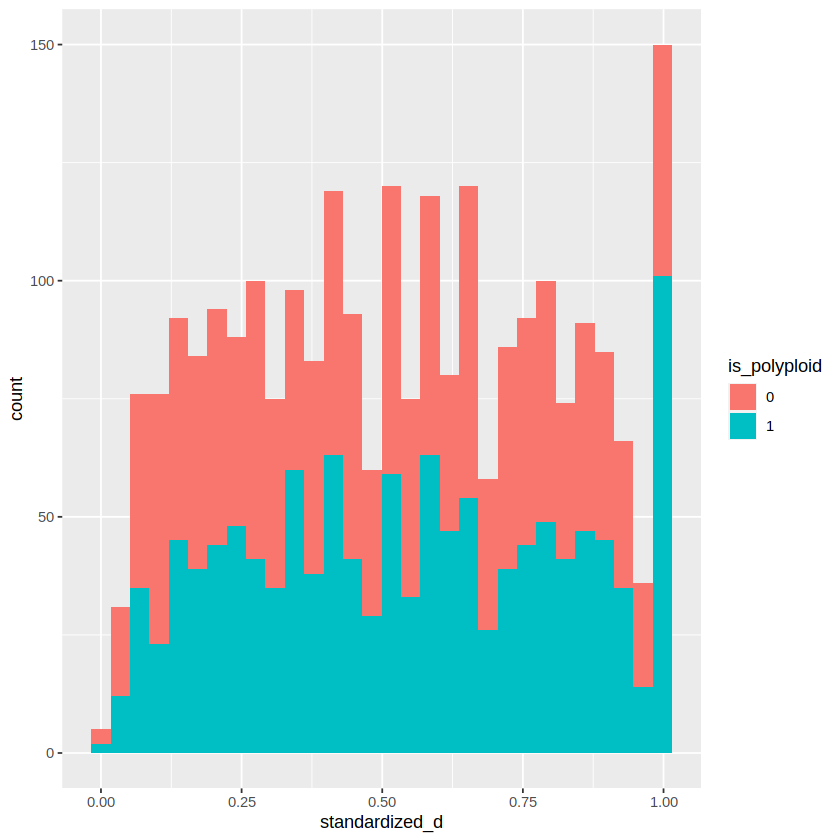

In [64]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_d, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_d ~ ploidy_age, data)
    abline(lm(formula = standardized_d ~ ploidy_age, data))
}

[1] "standardized_d~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          
standardized_d ~ is_polyploid + network_size + has_ploidy_variablity +  
    Lifeform + flw_color + mating_system + flw_shape + (1 | network_index)
Zero inflation:                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
   930.6   1006.5   -452.3    904.6     2512 

Random effects:

Conditional model:
 Groups        Name        Variance  Std.Dev. 
 network_index (Intercept) 3.123e-11 5.588e-06
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 2.85 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.294190   0.164858  -1.785 0.074341 .  
is_polyploid1          0.089486   0.042256   2.118 0.034202 *  
network_size           0.051276   0.077023   0.666 0.505591    
has_ploidy_va

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_d,fixed,10.579407744,0.001143543,-0.025270783,0.007769237,-3.25267226,0.001143253
flw_shape,standardized_d,fixed,14.391537562,0.000148468,0.156629839,0.041295189,3.79293187,0.000148879
has_ploidy_variablity,standardized_d,fixed,0.682499241,0.408727446,0.038370449,0.046443115,0.82618163,0.408701065
Intercept,standardized_d,none,NA,NA,-0.294190315,0.164857618,-1.78451150,0.074340587
is_polyploid,standardized_d,fixed,4.483714512,0.034219272,0.089485873,0.042256456,2.11768523,0.034201735
Lifeform,standardized_d,fixed,3.447815152,0.063335440,0.033526961,0.018045052,1.85795867,0.063174883
mating_system,standardized_d,fixed,0.006907734,0.933761867,-0.002192865,0.026384092,-0.08311314,0.933761581
network_index,standardized_d,random,NA,NA,NA,NA,NA,NA
network_size,standardized_d,fixed,0.443700915,0.505341569,0.051275800,0.077023260,0.66571838,0.505591125


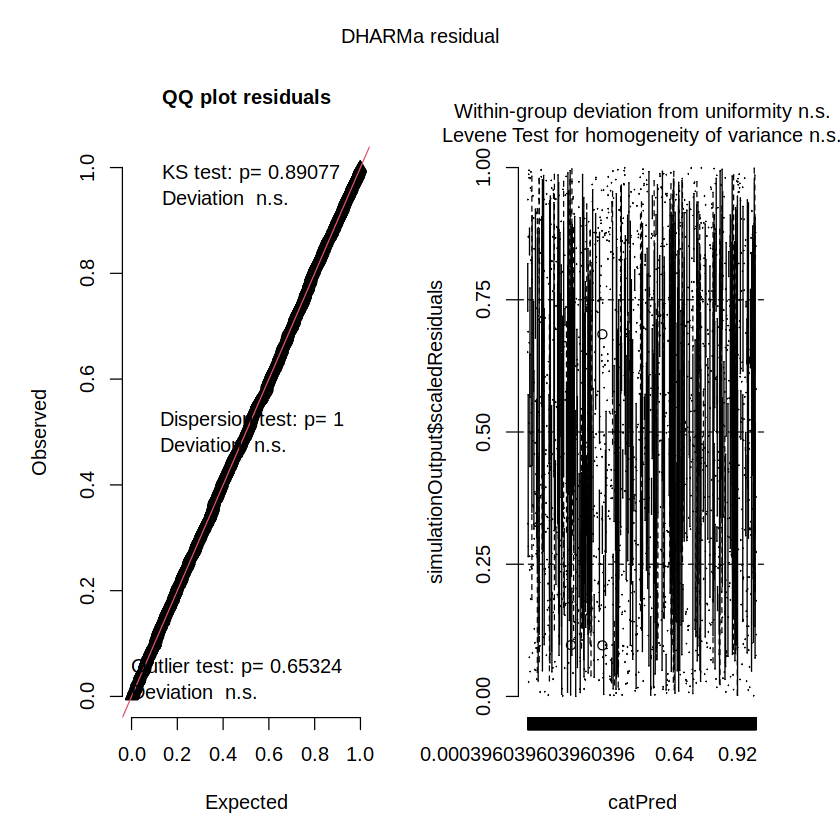

In [65]:
d_res_df = test_phylo_ploidy_level_effect(response_var="standardized_d")
d_res_df

## shannon diversity

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


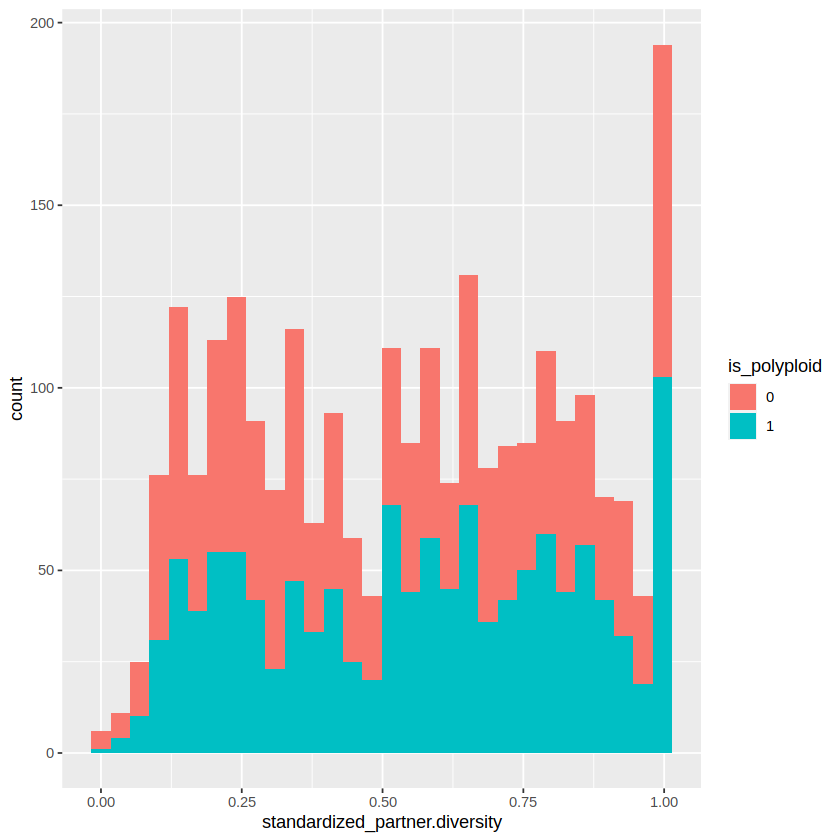

In [66]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_partner.diversity, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_partner.diversity ~ ploidy_age, data)
    abline(lm(formula = standardized_partner.diversity ~ ploidy_age, data))
}

[1] "standardized_partner.diversity~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          
standardized_partner.diversity ~ is_polyploid + network_size +  
    has_ploidy_variablity + Lifeform + flw_color + mating_system +  
    flw_shape + (1 | network_index)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1050.5   1126.4   -512.3   1024.5     2512 

Random effects:

Conditional model:
 Groups        Name        Variance  Std.Dev. 
 network_index (Intercept) 7.137e-11 8.448e-06
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 3.04 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.360086   0.162253  -8.383  < 2e-16 ***
is_polyploid1          0.067907   0.041829   1.623 0.104495    
network_size           

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_partner.diversity,fixed,1.31100369,2.522130e-01,0.008629976,0.007535185,1.1452906,2.520888e-01
flw_shape,standardized_partner.diversity,fixed,67.57175500,2.031572e-16,0.334017448,0.040539836,8.2392403,1.733075e-16
has_ploidy_variablity,standardized_partner.diversity,fixed,6.76747877,9.283389e-03,0.118672816,0.045609429,2.6019360,9.269915e-03
Intercept,standardized_partner.diversity,none,NA,NA,-1.360086289,0.162252799,-8.3825136,5.180922e-17
is_polyploid,standardized_partner.diversity,fixed,2.63256501,1.046925e-01,0.067907273,0.041829192,1.6234422,1.044949e-01
Lifeform,standardized_partner.diversity,fixed,13.02712666,3.070112e-04,0.064119074,0.017751537,3.6120294,3.038101e-04
mating_system,standardized_partner.diversity,fixed,13.85960747,1.969870e-04,0.096017668,0.025831618,3.7170598,2.015548e-04
network_index,standardized_partner.diversity,random,NA,NA,NA,NA,NA,NA
network_size,standardized_partner.diversity,fixed,0.03306349,8.557132e-01,0.013776306,0.075772722,0.1818109,8.557311e-01


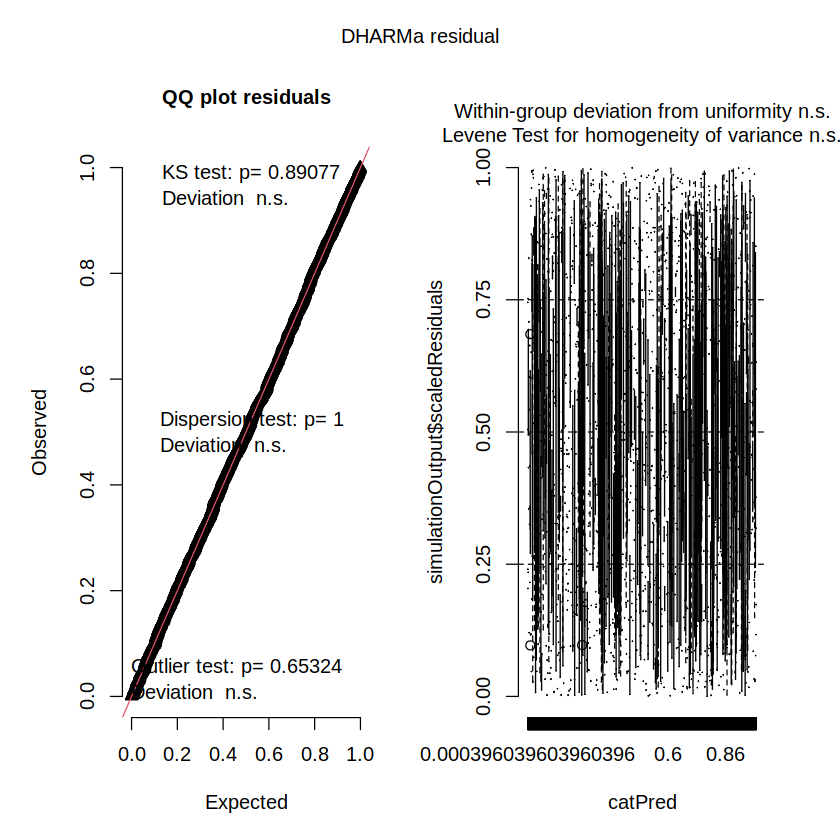

In [67]:
sd_res_df = test_phylo_ploidy_level_effect(response_var="standardized_partner.diversity")
sd_res_df

## normalized degree

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


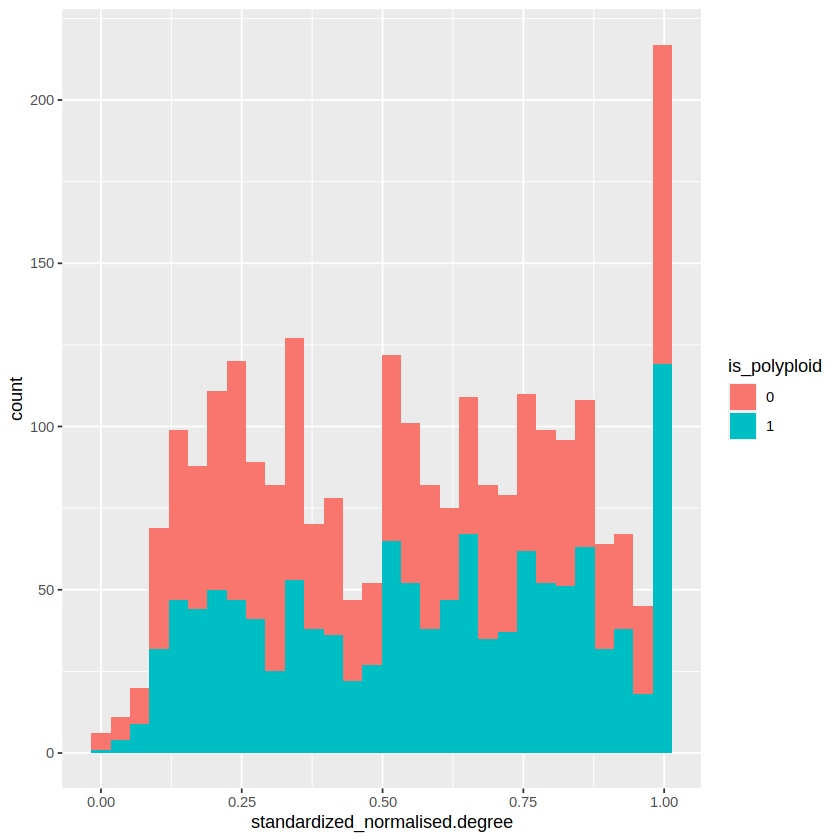

In [68]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_normalised.degree ~ ploidy_age, data)
    abline(lm(formula = standardized_normalised.degree ~ ploidy_age, data))
}

[1] "standardized_normalised.degree~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          
standardized_normalised.degree ~ is_polyploid + network_size +  
    has_ploidy_variablity + Lifeform + flw_color + mating_system +  
    flw_shape + (1 | network_index)
Zero inflation:                                  ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1144.2   1220.0   -559.1   1118.2     2512 

Random effects:

Conditional model:
 Groups        Name        Variance Std.Dev.
 network_index (Intercept) 1.44e-10 1.2e-05 
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 3.09 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.410588   0.161585  -8.730  < 2e-16 ***
is_polyploid1          0.085635   0.041656   2.056   0.0398 *  
network_size           0.05

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_normalised.degree,fixed,3.8600102,4.945003e-02,0.01475175,0.007503821,1.9658989,4.931029e-02
flw_shape,standardized_normalised.degree,fixed,55.7762469,8.120681e-14,0.30208401,0.040363336,7.4841190,7.202865e-14
has_ploidy_variablity,standardized_normalised.degree,fixed,2.0020912,1.570824e-01,0.06441243,0.045515465,1.4151769,1.570166e-01
Intercept,standardized_normalised.degree,none,NA,NA,-1.41058821,0.161584829,-8.7297069,2.553333e-18
is_polyploid,standardized_normalised.degree,fixed,4.2213423,3.991857e-02,0.08563493,0.041655623,2.0557832,3.980342e-02
Lifeform,standardized_normalised.degree,fixed,15.2445557,9.444862e-05,0.06908358,0.017682899,3.9068017,9.352584e-05
mating_system,standardized_normalised.degree,fixed,21.6479577,3.275586e-06,0.11984248,0.025829799,4.6396987,3.489176e-06
network_index,standardized_normalised.degree,random,NA,NA,NA,NA,NA,NA
network_size,standardized_normalised.degree,fixed,0.6102179,4.347058e-01,0.05873339,0.075228495,0.7807332,4.349594e-01


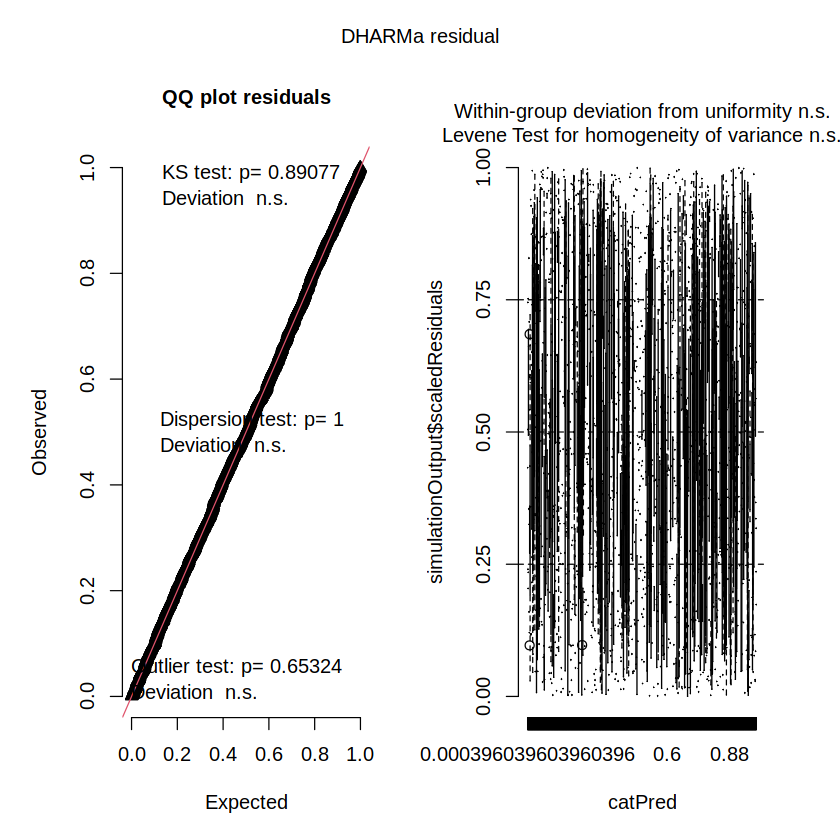

In [69]:
nd_res_df = test_phylo_ploidy_level_effect(response_var="standardized_normalised.degree")
nd_res_df

## betweenness

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


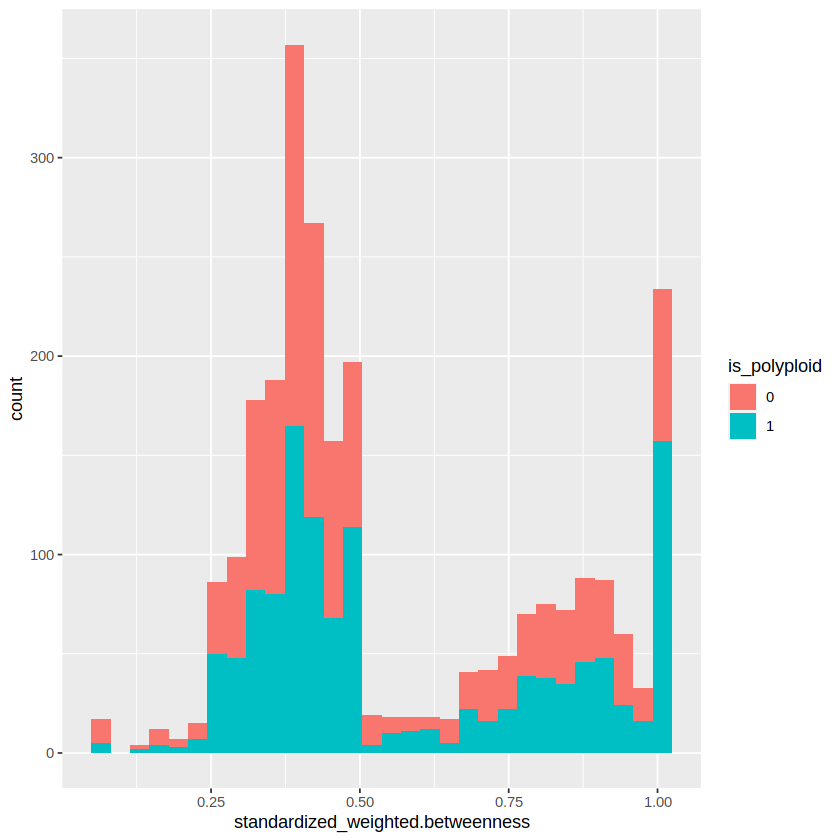

In [70]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_weighted.betweenness, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_weighted.betweenness ~ ploidy_age, data)
    abline(lm(formula = standardized_weighted.betweenness ~ ploidy_age, data))
}

[1] "standardized_weighted.betweenness~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.betweenness ~ is_polyploid + network_size +  
    has_ploidy_variablity + Lifeform + flw_color + mating_system +  
    flw_shape + (1 | network_index)
Zero inflation:                                     ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
   915.4    991.2   -444.7    889.4     2512 

Random effects:

Conditional model:
 Groups        Name        Variance  Std.Dev. 
 network_index (Intercept) 3.736e-11 6.112e-06
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 4.13 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.758045   0.145859  -5.197 2.02e-07 ***
is_polyploid1          0.045154   0.037805   1.194 0.232329    
network_size  

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_weighted.betweenness,fixed,0.3846553,0.5351222547,-0.00427313,0.006891019,-0.6201014,5.351910e-01
flw_shape,standardized_weighted.betweenness,fixed,6.5118457,0.0107158230,0.09363903,0.036684563,2.5525459,1.069388e-02
has_ploidy_variablity,standardized_weighted.betweenness,fixed,8.5102596,0.0035314968,0.12080488,0.041360964,2.9207461,3.491942e-03
Intercept,standardized_weighted.betweenness,none,NA,NA,-0.75804509,0.145858808,-5.1971157,2.024044e-07
is_polyploid,standardized_weighted.betweenness,fixed,1.4270345,0.2322490276,0.04515385,0.037805205,1.1943819,2.323286e-01
Lifeform,standardized_weighted.betweenness,fixed,12.7878360,0.0003488805,0.05725933,0.016004970,3.5775966,3.467680e-04
mating_system,standardized_weighted.betweenness,fixed,13.3495147,0.0002584895,0.08501158,0.023309155,3.6471326,2.651830e-04
network_index,standardized_weighted.betweenness,random,NA,NA,NA,NA,NA,NA
network_size,standardized_weighted.betweenness,fixed,0.1579221,0.6910768018,0.02684635,0.067567212,0.3973281,6.911255e-01


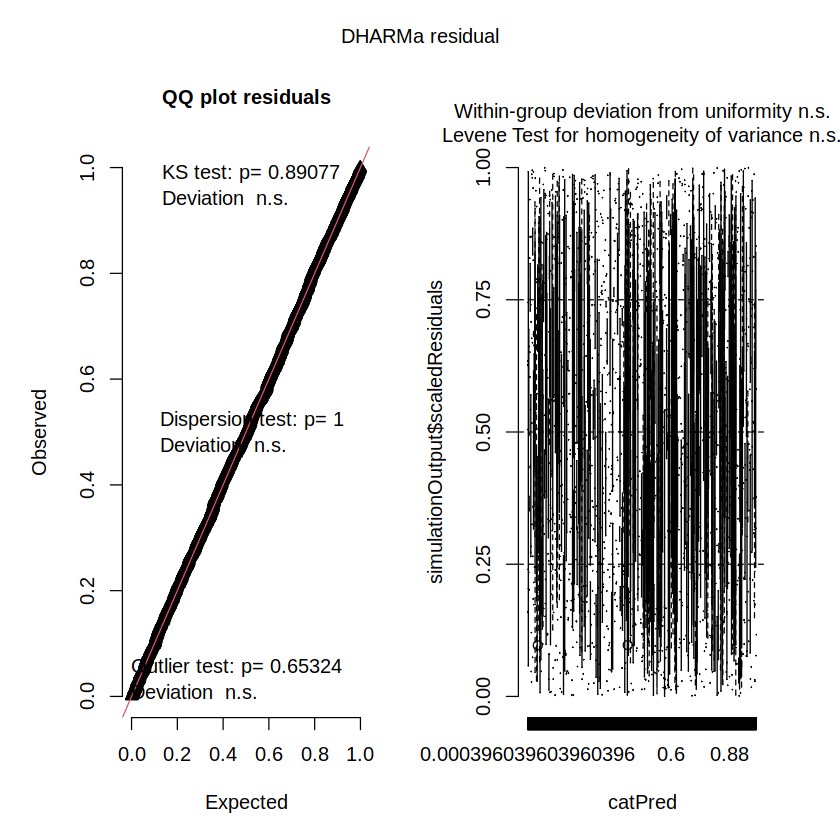

In [71]:
bet_res_df = test_phylo_ploidy_level_effect(response_var="standardized_weighted.betweenness")
bet_res_df

# closeness

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


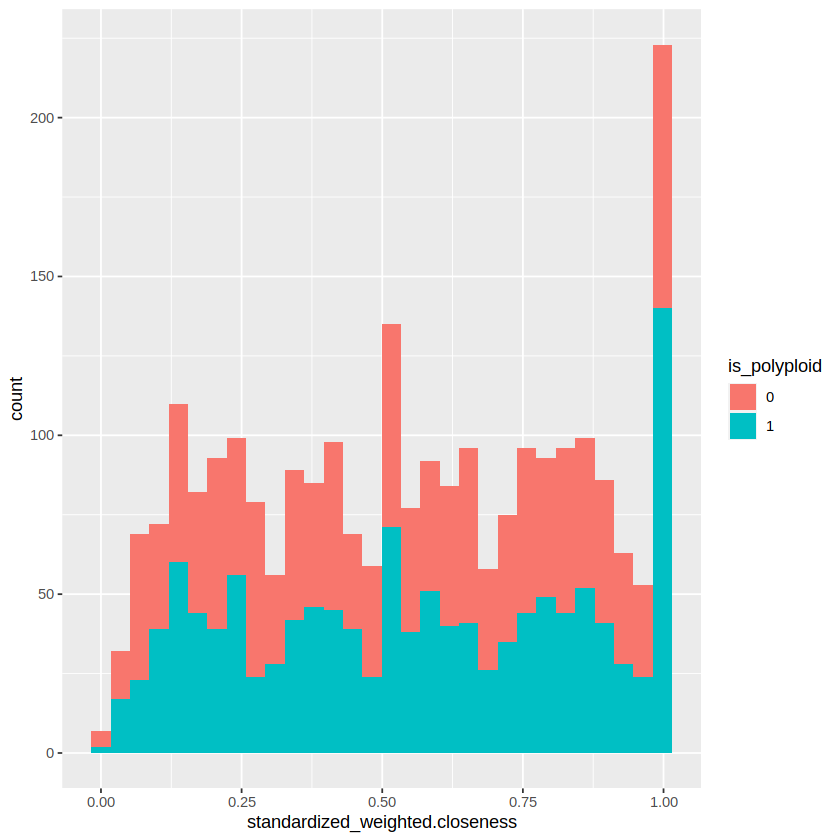

In [72]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_weighted.closeness, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_weighted.closeness ~ ploidy_age, data)
    abline(lm(formula = standardized_weighted.closeness ~ ploidy_age, data))
}

[1] "standardized_weighted.closeness~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          
standardized_weighted.closeness ~ is_polyploid + network_size +  
    has_ploidy_variablity + Lifeform + flw_color + mating_system +  
    flw_shape + (1 | network_index)
Zero inflation:                                   ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1351.4   1427.2   -662.7   1325.4     2512 

Random effects:

Conditional model:
 Groups        Name        Variance  Std.Dev.
 network_index (Intercept) 1.988e-10 1.41e-05
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 2.67 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.890116   0.168945  -5.269 1.37e-07 ***
is_polyploid1          0.042607   0.043333   0.983   0.3255    
network_size          

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_weighted.closeness,fixed,4.911806e+00,2.667374e-02,0.017380689,0.007841642,2.21646056,2.665998e-02
flw_shape,standardized_weighted.closeness,fixed,2.498274e-01,6.171966e-01,-0.021144092,0.042306587,-0.49978249,6.172282e-01
has_ploidy_variablity,standardized_weighted.closeness,fixed,5.142905e-01,4.732874e-01,0.034100681,0.047546287,0.71721018,4.732444e-01
Intercept,standardized_weighted.closeness,none,NA,NA,-0.890116411,0.168944593,-5.26868835,1.374020e-07
is_polyploid,standardized_weighted.closeness,fixed,9.671337e-01,3.253961e-01,0.042606619,0.043333025,0.98323667,3.254910e-01
Lifeform,standardized_weighted.closeness,fixed,6.034374e+00,1.402992e-02,0.045172149,0.018368378,2.45923446,1.392337e-02
mating_system,standardized_weighted.closeness,fixed,2.822149e+01,1.081964e-07,0.142813132,0.027050624,5.27947655,1.295535e-07
network_index,standardized_weighted.closeness,random,NA,NA,NA,NA,NA,NA
network_size,standardized_weighted.closeness,fixed,1.727891e-04,9.895122e-01,0.001023376,0.077836975,0.01314769,9.895100e-01


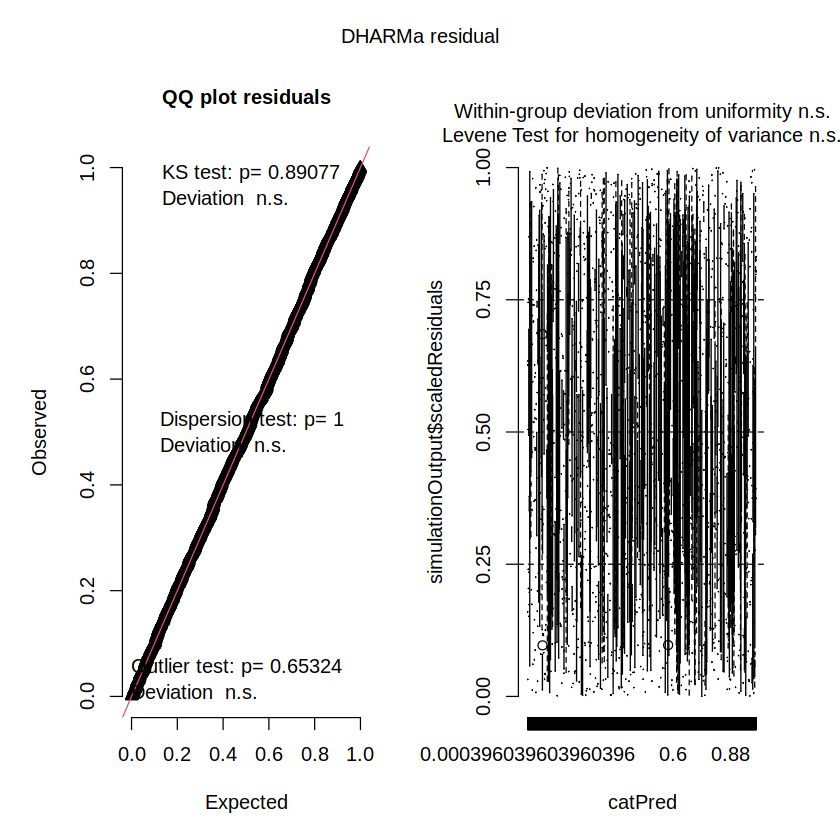

In [73]:
clos_res_df = test_phylo_ploidy_level_effect(response_var="standardized_weighted.closeness")
clos_res_df

## hub score

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


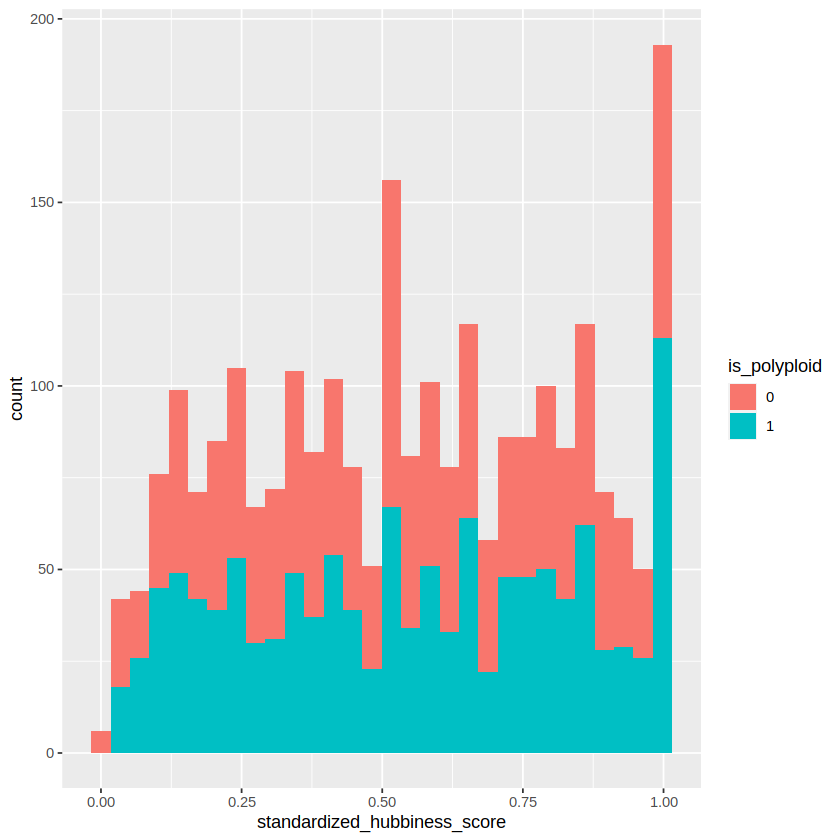

In [74]:
if (predictor == "is_polyploid")
{
    ggplot(data, aes(x = standardized_hubbiness_score, fill = is_polyploid)) + geom_histogram()
} else {
    plot(standardized_hubbiness_score ~ ploidy_age, data)
    abline(lm(formula = standardized_hubbiness_score ~ ploidy_age, data))
}

[1] "standardized_hubbiness_score~ is_polyploid + network_size + has_ploidy_variablity + Lifeform + flw_color + mating_system + flw_shape + (1|network_index)"
 Family: ordbeta  ( logit )
Formula:          standardized_hubbiness_score ~ is_polyploid + network_size +  
    has_ploidy_variablity + Lifeform + flw_color + mating_system +  
    flw_shape + (1 | network_index)
Zero inflation:                                ~1
Data: data

     AIC      BIC   logLik deviance df.resid 
  1199.6   1275.5   -586.8   1173.6     2512 

Random effects:

Conditional model:
 Groups        Name        Variance  Std.Dev. 
 network_index (Intercept) 1.961e-11 4.428e-06
Number of obs: 2525, groups:  network_index, 530

Dispersion parameter for ordbeta family (): 2.78 

Conditional model:
                       Estimate Std. Error z value Pr(>|z|)  
(Intercept)           -0.314382   0.165933  -1.895   0.0581 .
is_polyploid1          0.019841   0.042795   0.464   0.6429  
network_size           0.158171   0.

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
flw_color,standardized_hubbiness_score,fixed,5.59485052,0.01801335,0.018496984,0.00781810,2.3659180,0.01798543
flw_shape,standardized_hubbiness_score,fixed,0.54228090,0.46148898,-0.030714667,0.04170628,-0.7364519,0.46145573
has_ploidy_variablity,standardized_hubbiness_score,fixed,0.10435891,0.74666018,-0.015140185,0.04686628,-0.3230507,0.74665683
Intercept,standardized_hubbiness_score,none,NA,NA,-0.314382066,0.16593319,-1.8946304,0.05814139
is_polyploid,standardized_hubbiness_score,fixed,0.21497849,0.64289299,0.019841447,0.04279497,0.4636397,0.64290589
Lifeform,standardized_hubbiness_score,fixed,0.04870411,0.82533375,0.004009526,0.01816756,0.2206970,0.82532835
mating_system,standardized_hubbiness_score,fixed,1.31813988,0.25092616,0.030422476,0.02651558,1.1473435,0.25123969
network_index,standardized_hubbiness_score,random,NA,NA,NA,NA,NA,NA
network_size,standardized_hubbiness_score,fixed,4.21367799,0.04009930,0.158171182,0.07722400,2.0482129,0.04053915


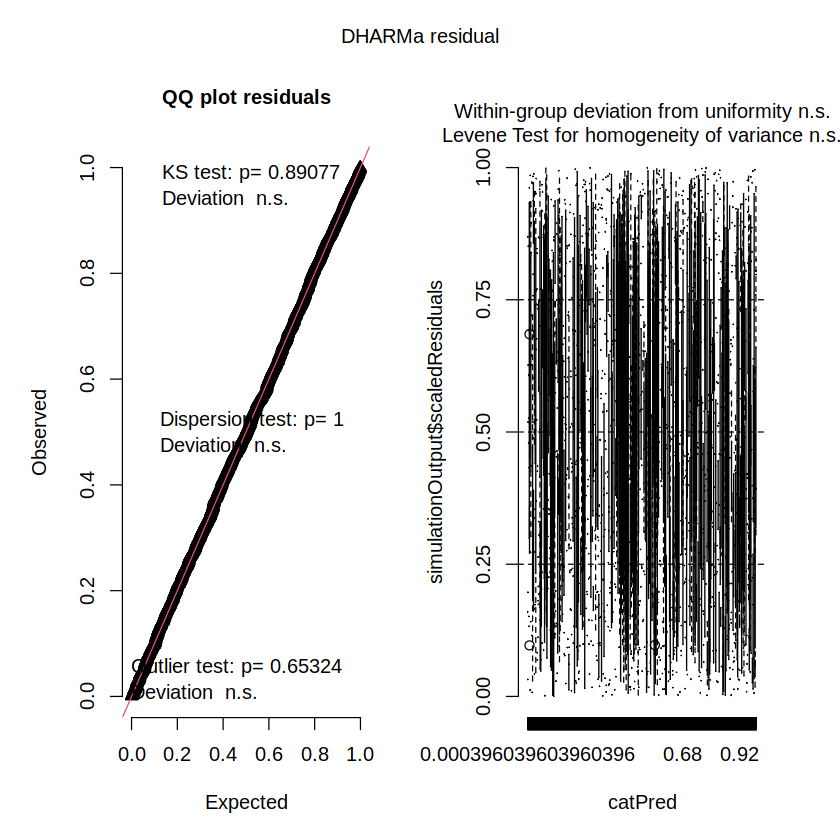

In [75]:
hub_res_df = test_phylo_ploidy_level_effect(response_var="standardized_hubbiness_score")
hub_res_df

In [76]:
full_df = rbind(rbind(rbind(rbind(rbind(d_res_df, sd_res_df),nd_res_df),bet_res_df),clos_res_df),hub_res_df)
full_df["significant_by_lrt"] = full_df$lrt_pvalue <= 0.05
full_df["significant_by_wald_test"] = full_df$z_test_pvalue <= 0.05
write.csv(full_df, pglmm_res_path)

In [77]:
sig_df = full_df[full_df$z_test_pvalue <= 0.05, ]
drop_na(sig_df, any_of(c("response_variable")))

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,significant_by_lrt,significant_by_wald_test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
flw_color,standardized_d,fixed,10.579408,1.143543e-03,-0.02527078,0.007769237,-3.252672,1.143253e-03,TRUE,TRUE
flw_shape,standardized_d,fixed,14.391538,1.484680e-04,0.15662984,0.041295189,3.792932,1.488790e-04,TRUE,TRUE
is_polyploid,standardized_d,fixed,4.483715,3.421927e-02,0.08948587,0.042256456,2.117685,3.420173e-02,TRUE,TRUE
flw_shape1,standardized_partner.diversity,fixed,67.571755,2.031572e-16,0.33401745,0.040539836,8.239240,1.733075e-16,TRUE,TRUE
has_ploidy_variablity1,standardized_partner.diversity,fixed,6.767479,9.283389e-03,0.11867282,0.045609429,2.601936,9.269915e-03,TRUE,TRUE
Intercept1,standardized_partner.diversity,none,NA,NA,-1.36008629,0.162252799,-8.382514,5.180922e-17,NA,TRUE
Lifeform1,standardized_partner.diversity,fixed,13.027127,3.070112e-04,0.06411907,0.017751537,3.612029,3.038101e-04,TRUE,TRUE
mating_system1,standardized_partner.diversity,fixed,13.859607,1.969870e-04,0.09601767,0.025831618,3.717060,2.015548e-04,TRUE,TRUE
flw_color2,standardized_normalised.degree,fixed,3.860010,4.945003e-02,0.01475175,0.007503821,1.965899,4.931029e-02,TRUE,TRUE


# pair analysis

In [108]:
# need to use beta distribution for all variables distributed between 0 and 1
# https://stats.stackexchange.com/questions/508023/which-link-function-could-be-used-for-a-glm-where-the-response-is-per-cent-0
# https://rpubs.com/nicoleknight/936037
pair_data <- read.csv(pair_data_path)


test_pair_ploidy_level_effect <- function(response_var){
    func_data = pair_data %>% drop_na(response_var)
    fixed_covars = c("pair_type")
    random_covars = c("network_id", "phylogenetic_dist")
    fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
    random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
    complete_formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
    
    res_df <- data.frame(matrix(ncol = 5, nrow = length(fixed_covars)+length(random_covars)+1))
    x <- c("response_variable", "variable", "type", "lrt_statistic", "lrt_pvalue")
    colnames(res_df) <- x
    res_df["response_variable"] = rep(response_var, length(fixed_covars)+length(random_covars)+1)
    res_df["variable"] = c(fixed_covars, random_covars, c("Intercept"))
    res_df["type"] = c(rep(c("fixed"), length(fixed_covars)), rep(c("random"), length(random_covars)), c("none"))
    rownames(res_df) <-res_df$variable
    res_df$variable <- NULL
  
    complete_formula = as.formula(complete_formula_str)
    
    model.full <- glmmTMB(formula=complete_formula, 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
    model_res = summary(model.full)
    print(model_res)
    res = simulateResiduals(model.full)
    plot(res, asFactor = T)
    
    fixed_vars_res = model_res$coefficients$cond
    rownames(fixed_vars_res) = to_vec(for (item in rownames(fixed_vars_res)) str_replace(gsub('[^[:alpha:]^_]', '', item), "typepd", "type"))
    colnames(fixed_vars_res) =  c("coefficient", "standard_error", "z_test_statistic", "z_test_pvalue")
    res_df = merge(res_df, fixed_vars_res, by=0, all=T)
    rownames(res_df) <-res_df$Row.names
    res_df$Row.names <- NULL
    
    for (fixed_var in fixed_covars)
    {
        subset_fixed_covars = ifelse(fixed_covars != fixed_var, fixed_covars, "")
        fixed_covars_formula_str = paste0(as.list(subset_fixed_covars), collapse = " + ")
        random_covars_formula_str = paste0("(1|", paste0(as.list(random_covars), collapse = ") + (1|"), ")")
        formula_str = paste0(response_var, '~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
        if (length(subset_fixed_covars) == 0)
            {
            formula_str = paste0(response_var, '~ ', random_covars_formula_str)
            }
        model.reduced <- glmmTMB(formula=as.formula(formula_str), 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
        lrt <- anova(model.full, model.reduced)
        res_df[fixed_var, "lrt_statistic"] = lrt[2,"Chisq"]
        res_df[fixed_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
    }
                                      
    for (random_var in random_covars)
    {
        if (random_var != "sample_id")
        {
            subset_random_covars = random_covars[which(random_covars != random_var)]
            fixed_covars_formula_str = paste0(as.list(fixed_covars), collapse = " + ")
            random_covars_formula_str = paste0("(1|", paste0(as.list(subset_random_covars), collapse = ") + (1|"), ")")
            formula_str = paste0(response_var, ' ~ ', fixed_covars_formula_str, ' + ', random_covars_formula_str)
            model.reduced <- glmmTMB(formula=as.formula(formula_str), 
                , family=ordbeta(link = "logit")
                 , ziformula=~0
                 , data=func_data
                 , control= glmmTMBControl(rank_check = "skip")
                 , start = list(psi = c(-1, 1))
                 )
            lrt <- anova(model.full, model.reduced)
            res_df[random_var, "lrt_statistic"] = lrt[2,"Chisq"]
            res_df[random_var, "lrt_pvalue"] = lrt[2,"Pr(>Chisq)"]
        }
    }
                                      
    return (res_df)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


ERROR: Error in eval(predvars, data, env): object 'bs' not found


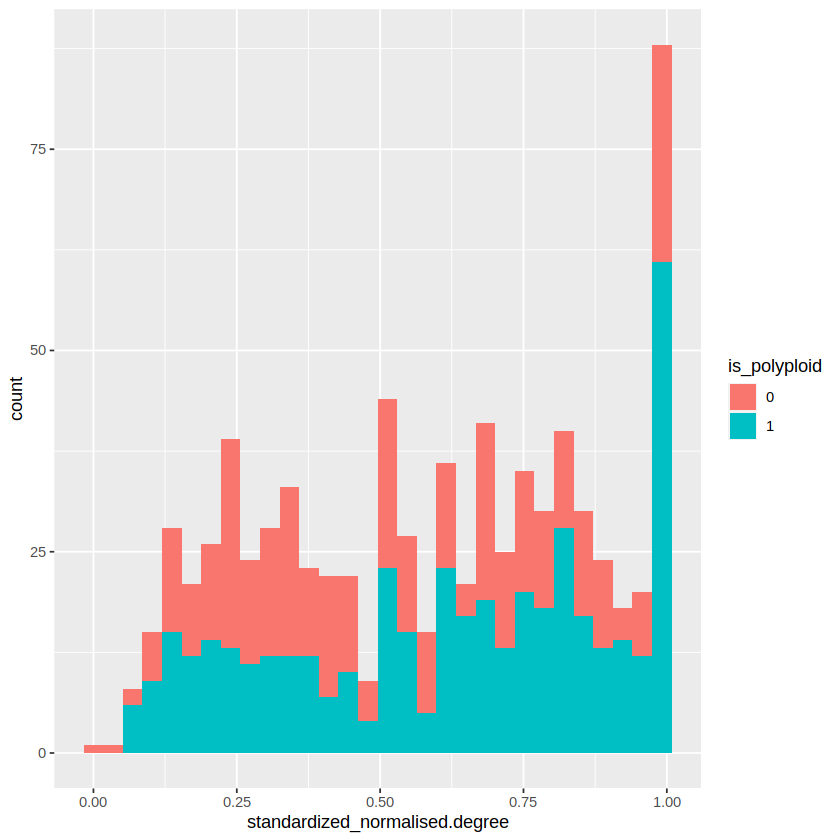

In [109]:
ggplot(data, aes(x = standardized_normalised.degree, fill = is_polyploid)) + geom_histogram()
if (include_metadata)
{
glmm_fit <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+bs+(is_polyploid*bs)+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("full model")
print(summary(glmm_fit))
    
glmm_fit_reduced <- phylo_glmmTMB(formula=standardized_normalised.degree~bs+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("\nreduced model")
print(summary(glmm_fit_reduced))
} else
{
glmm_fit <- phylo_glmmTMB(formula=standardized_normalised.degree~is_polyploid+(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("full model")
print(summary(glmm_fit))
    
glmm_fit_reduced <- phylo_glmmTMB(formula=standardized_normalised.degree~(1|sample_id) +(1|network_id)+(1|network_size)
, family=ordbeta(link = "logit")
, ziformula=~1
, data=data
, phylonm = "sample_id"
, phylo = tree
, control= glmmTMBControl(rank_check = "skip"),
)
print("\nreduced model")
print(summary(glmm_fit_reduced))
}
print("\nmodel comparison")
print(summary(lrtest(glmm_fit, glmm_fit_reduced)))
print("\nmodel diagnostics")
res = simulateResiduals(glmm_fit)
plot(res, asFactor = T)

## deprecated - perform test on poly-diplo pairs

In [ ]:
mixed = glmmTMB(formula=standardized_d_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

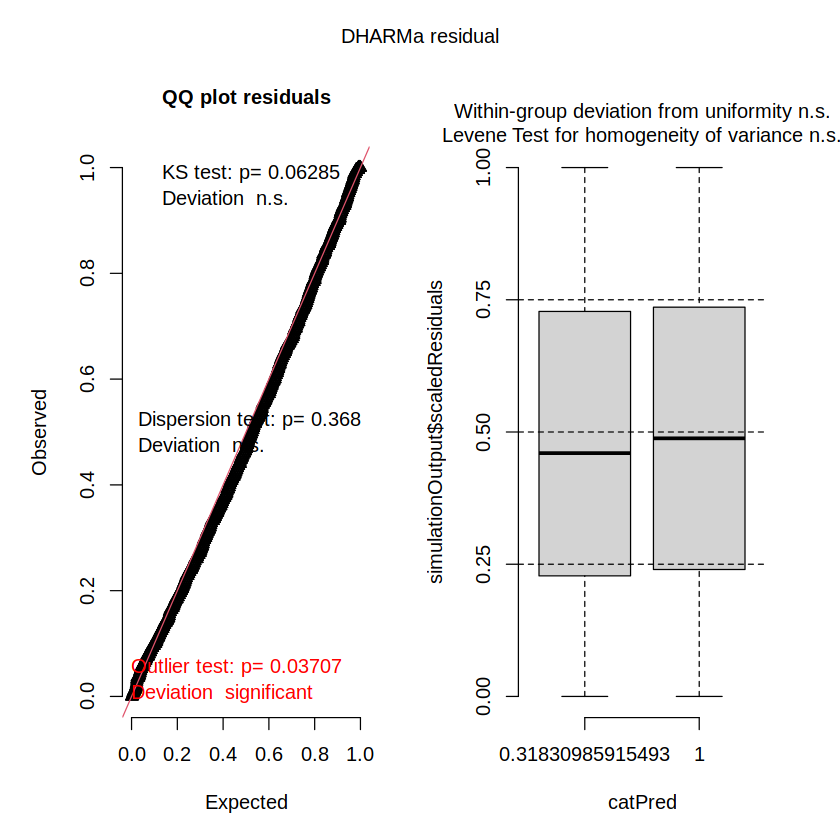

In [32]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


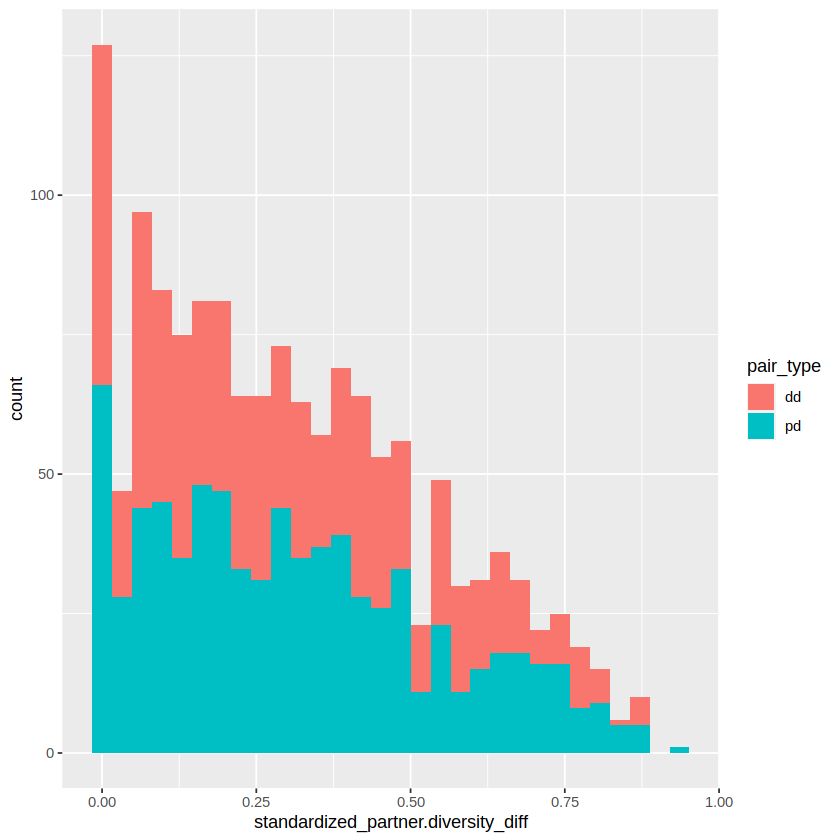

In [33]:
ggplot(pair_data, aes(x=standardized_partner.diversity_diff, fill = pair_type)) + geom_histogram()

In [34]:
mixed = glmmTMB(formula=standardized_partner.diversity_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_partner.diversity_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   134.9    166.6    -61.5    122.9     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05653  0.2378  
 phylogenetic_dist (Intercept) 0.07794  0.2792  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 4.86 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.65107    0.04656 -13.985   <2e-16 ***
pair_typepd  0.01039    0.05698   0.182    0.855    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.43451    0.09642  -25.25   <2e-16 ***
---
Signif. co

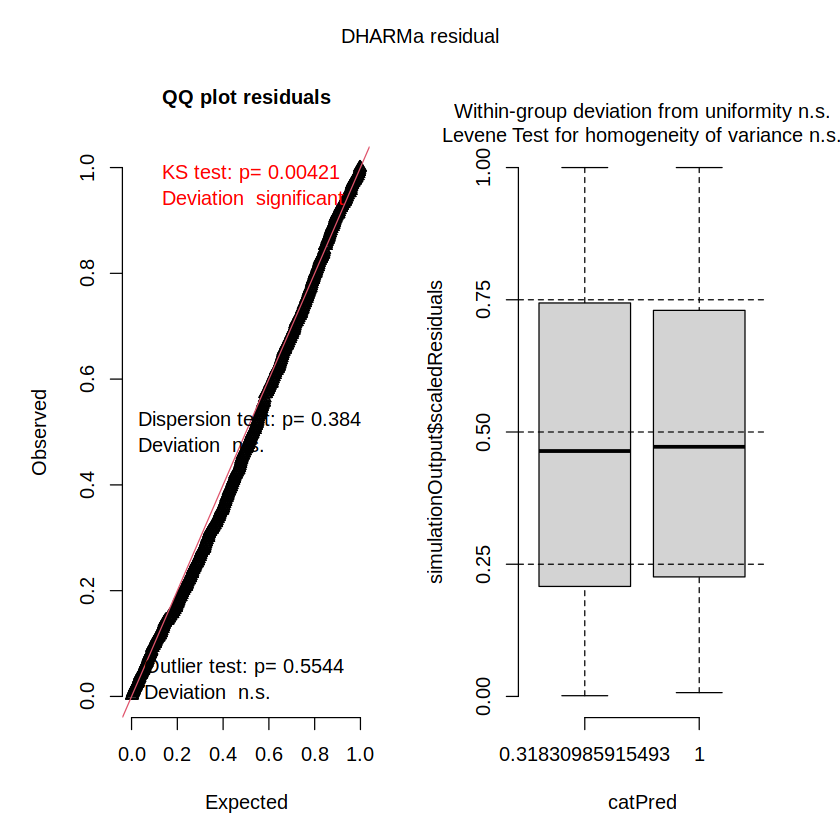

In [35]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


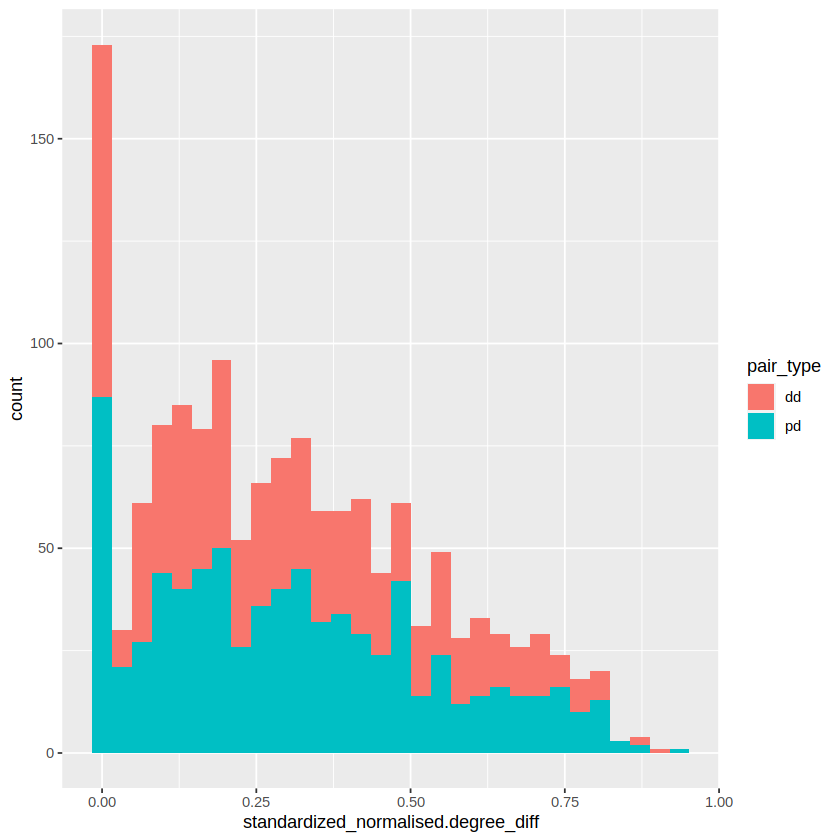

In [36]:
ggplot(pair_data, aes(x=standardized_normalised.degree_diff, fill = pair_type)) + geom_histogram()

In [37]:
mixed = glmmTMB(formula=standardized_normalised.degree_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_normalised.degree_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                       ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
   370.6    402.3   -179.3    358.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.05961  0.2441  
 phylogenetic_dist (Intercept) 0.06366  0.2523  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.47 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.60420    0.04542 -13.303   <2e-16 ***
pair_typepd  0.02585    0.05492   0.471    0.638    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.00054    0.08101   -24.7   <2e-16 ***
---
Signif. co

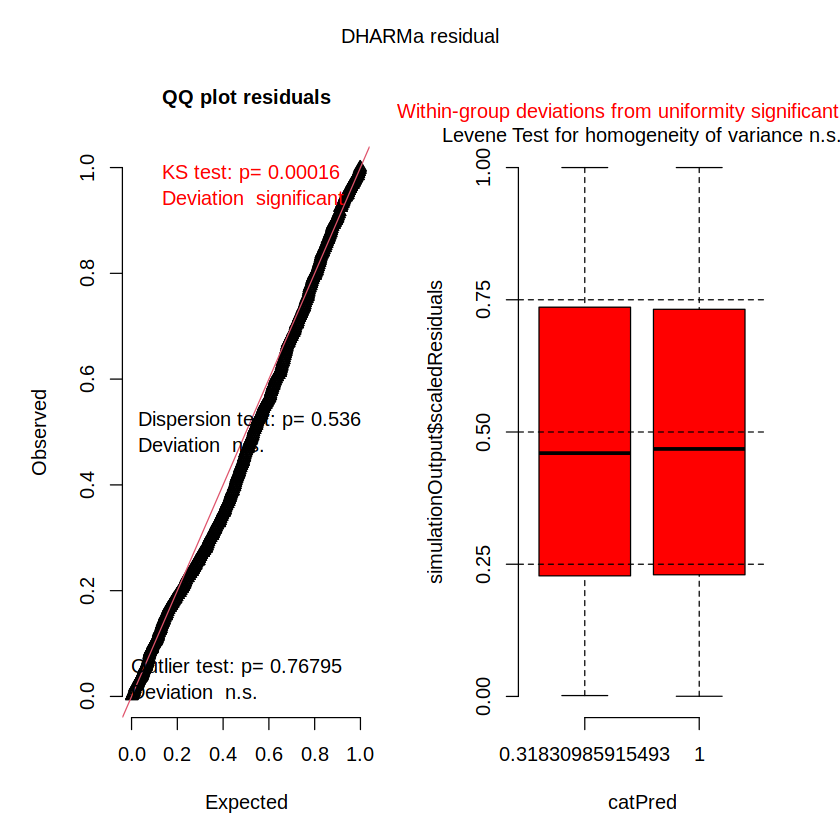

In [38]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


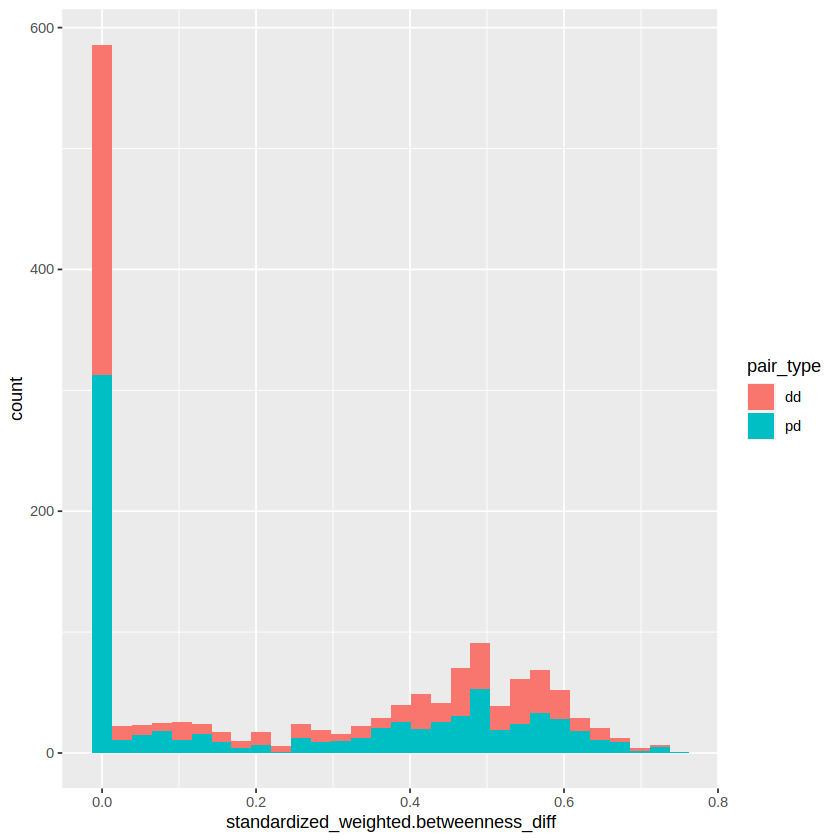

In [39]:
ggplot(pair_data, aes(x=standardized_weighted.betweenness_diff, fill = pair_type)) + geom_histogram()

In [40]:
mixed = glmmTMB(formula=standardized_weighted.betweenness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.betweenness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                          ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  1462.3   1493.9   -725.1   1450.3     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.04021  0.2005  
 phylogenetic_dist (Intercept) 0.15977  0.3997  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  7.4 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.37683    0.05347  -7.047 1.83e-12 ***
pair_typepd -0.01805    0.06744  -0.268    0.789    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.40776    0.05358   -7.61 2.74e-14 ***
---
Sign

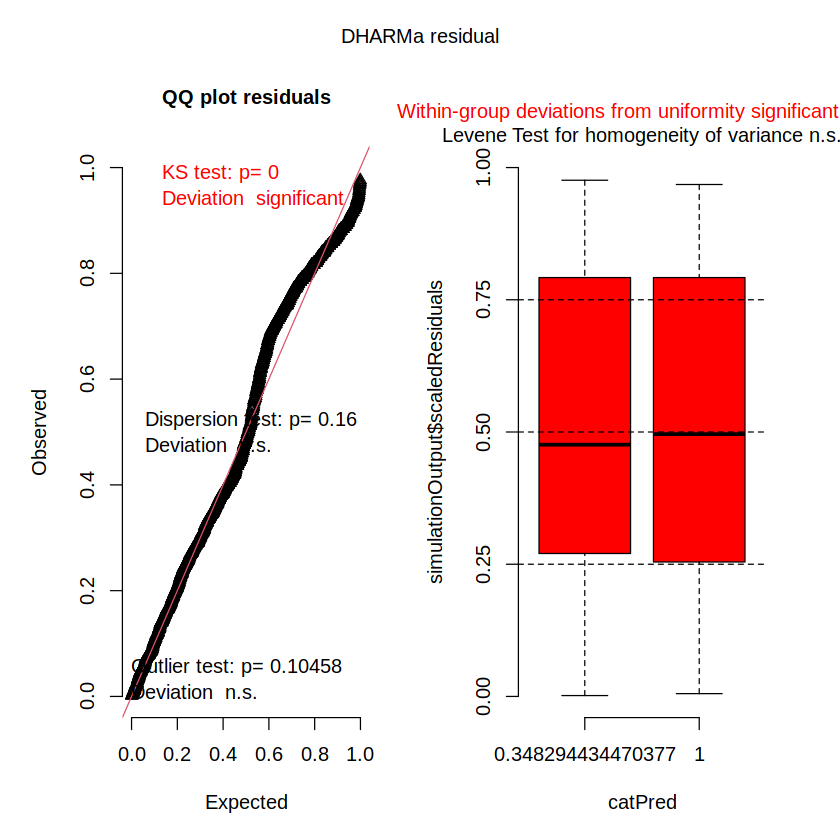

In [41]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


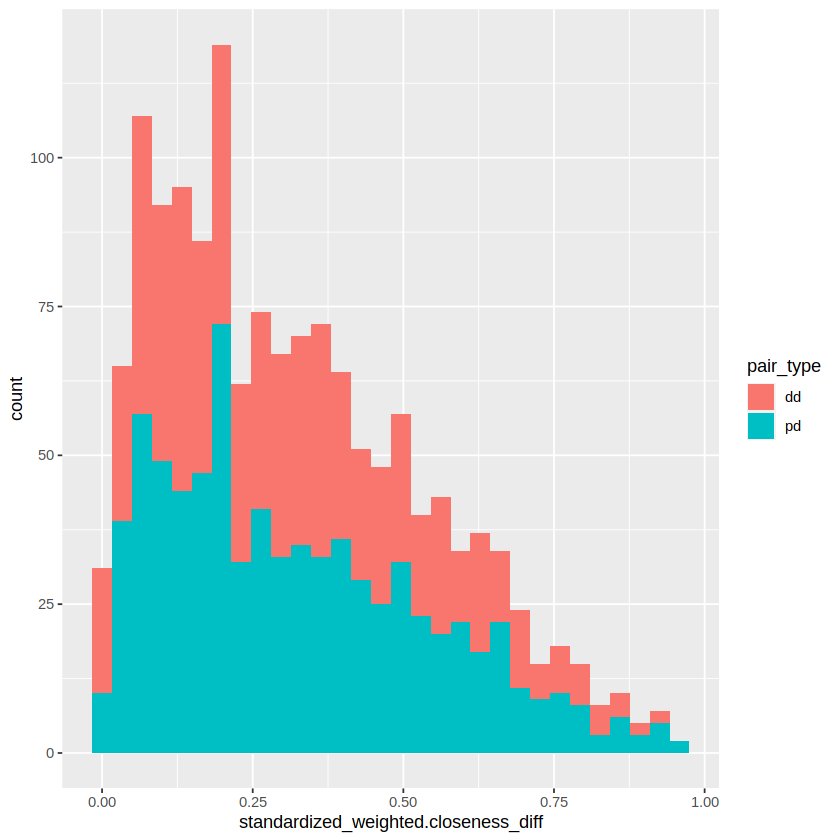

In [42]:
ggplot(pair_data, aes(x=standardized_weighted.closeness_diff, fill = pair_type)) + geom_histogram()

In [43]:
mixed = glmmTMB(formula=standardized_weighted.closeness_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_weighted.closeness_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                        ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -490.6   -458.9    251.3   -502.6     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.01343  0.1159  
 phylogenetic_dist (Intercept) 0.09186  0.3031  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family ():  4.5 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.74985    0.04340 -17.279   <2e-16 ***
pair_typepd  0.03649    0.05626   0.649    0.517    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.1292     0.2102  -19.65   <2e-16 ***
---
Signif. 

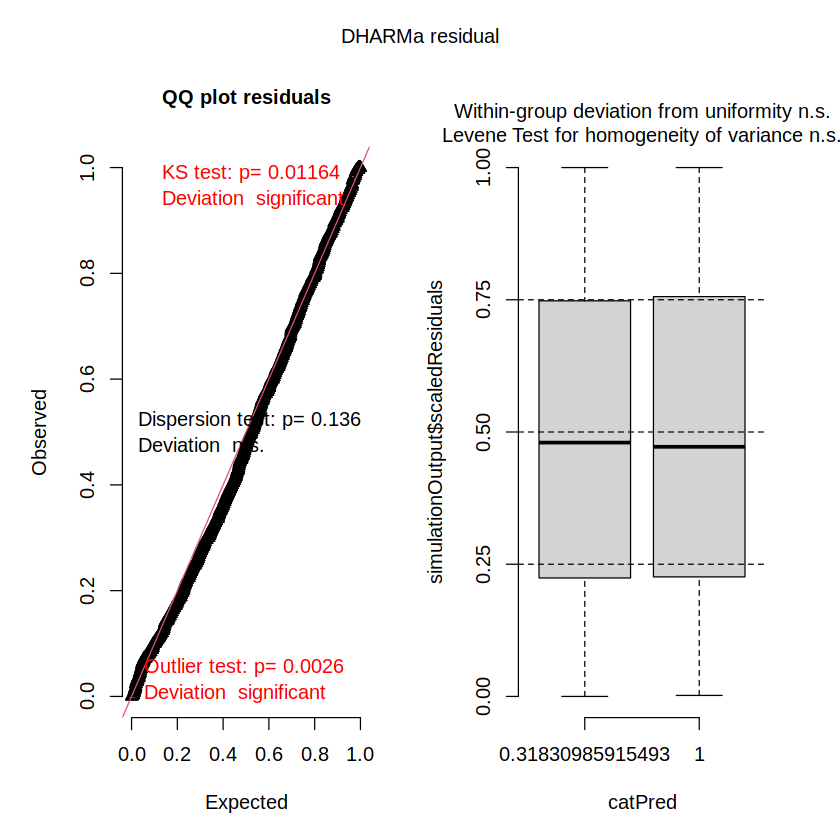

In [44]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


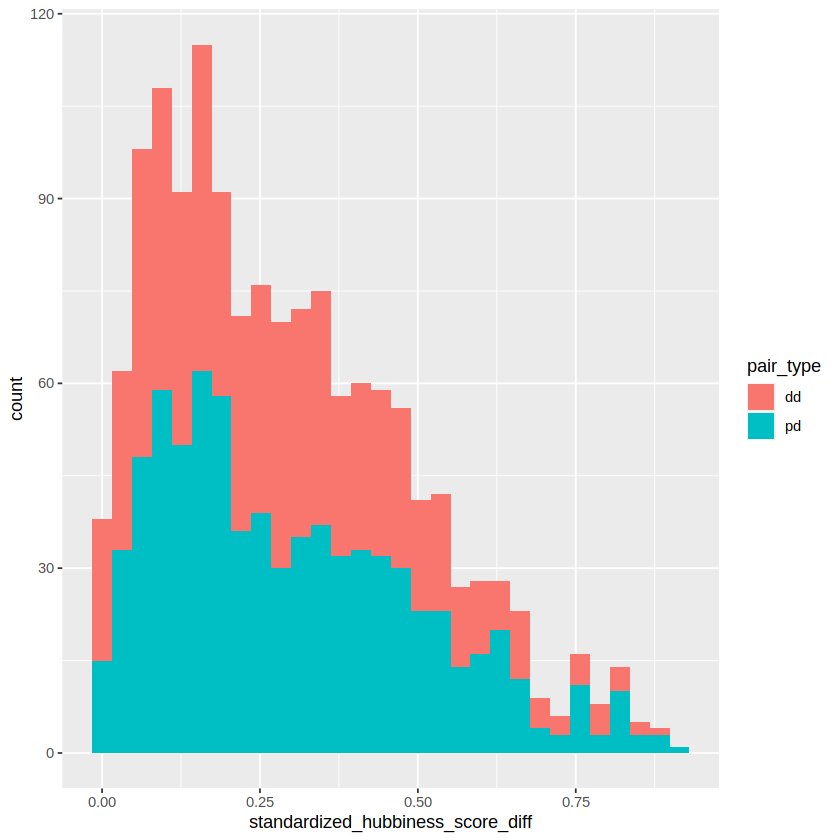

In [45]:
ggplot(pair_data, aes(x=standardized_hubbiness_score_diff, fill = pair_type)) + geom_histogram()


In [46]:
mixed = glmmTMB(formula=standardized_hubbiness_score_diff~pair_type+(1|network_id)+(1|phylogenetic_dist), 
                , family=beta_family(link="logit")
                , ziformula=~1
                , data=pair_data
                , control= glmmTMBControl(rank_check = "skip"))
print(summary(mixed))

 Family: beta  ( logit )
Formula:          
standardized_hubbiness_score_diff ~ pair_type + (1 | network_id) +  
    (1 | phylogenetic_dist)
Zero inflation:                                     ~1
Data: pair_data

     AIC      BIC   logLik deviance df.resid 
  -661.7   -630.0    336.9   -673.7     1446 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.02040  0.1428  
 phylogenetic_dist (Intercept) 0.06243  0.2499  
Number of obs: 1452, groups:  network_id, 287; phylogenetic_dist, 615

Dispersion parameter for beta family (): 5.17 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.88265    0.04149 -21.272   <2e-16 ***
pair_typepd  0.06837    0.05284   1.294    0.196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Zero-inflation model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -3.8586     0.1845  -20.91   <2e-16 ***
---
Signif. codes:

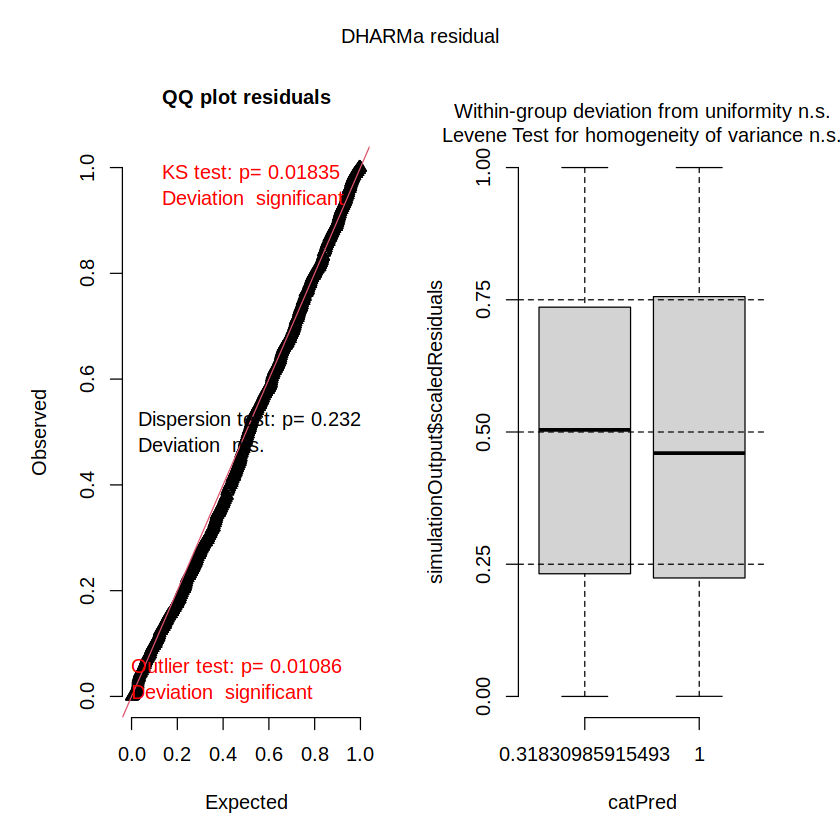

In [47]:
res = simulateResiduals(mixed)
plot(res, asFactor = T)

## compute niche overlap across pairs

In [589]:
get_niche_overlap <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = as.matrix(vegdist(network, method="horn"))
    if (!((member1 %in% rownames(res) && (member2 %in% rownames(res)))))
        {
        return(NA)
        }
    return(res[c(member1),c(member2)])  
    }

In [590]:
if (!("horn_index" %in% colnames(pair_data)))
{
    pair_data["horn_index"] = pbmcmapply(get_niche_overlap, 
                                         pair_data$network_path, 
                                         pair_data$member1, 
                                         pair_data$member2,
                                         ignore.interactive = getOption("ignore.interactive", T),
                                         mc.cores = 10)
    write.csv(pair_data, pair_data_path)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 272 rows containing non-finite values (`stat_bin()`).”


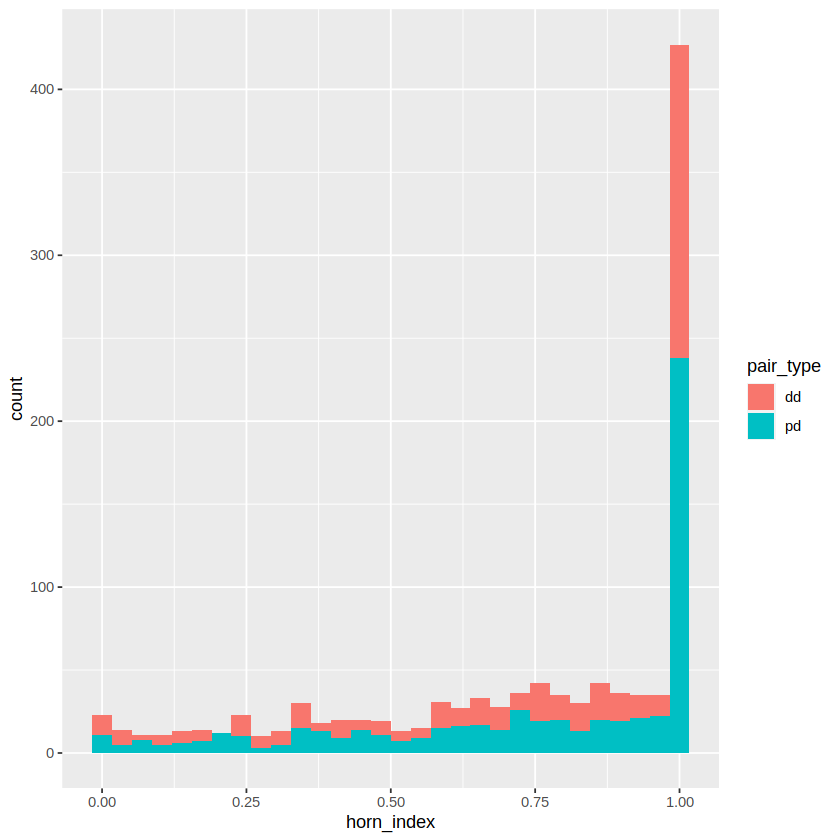

In [591]:
ggplot(pair_data, aes(x=horn_index, fill = pair_type)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
horn_index ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Data: func_data

     AIC      BIC   logLik deviance df.resid 
  1529.0   1564.2   -757.5   1515.0     1109 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 0.1947   0.4412  
 phylogenetic_dist (Intercept) 0.1940   0.4405  
Number of obs: 1116, groups:  network_id, 223; phylogenetic_dist, 508

Dispersion parameter for ordbeta family (): 3.19 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.55406    0.08585   6.454 1.09e-10 ***
pair_typepd  0.07694    0.08585   0.896     0.37    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


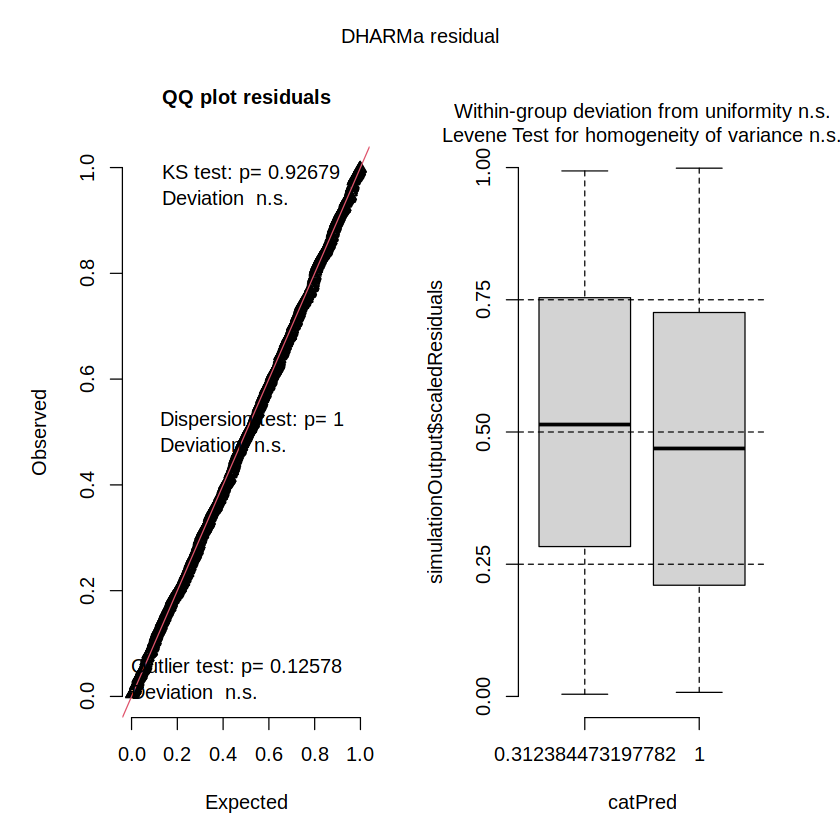

In [592]:
horn_res_df = test_pair_ploidy_level_effect("horn_index")                                         

In [593]:
horn_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,horn_index,none,NA,NA,0.55406074,0.08584804,6.4539710,1.089567e-10
network_id,horn_index,random,34.447036,4.380093e-09,NA,NA,NA,NA
pair_type,horn_index,fixed,0.801802,3.705551e-01,0.07693752,0.08585152,0.8961696,3.701622e-01
phylogenetic_dist,horn_index,random,22.917735,1.690846e-06,NA,NA,NA,NA


# compute module sharing between pairs

In [594]:
get_module_sharing <-function(network_path, member1, member2)
    {
    network = process_network(network_path)
    res = computeModules(network)
    modules_matrix = as.matrix(slot(res, "modules"))
    if (!((member1 %in% rownames(network) && (member2 %in% rownames(network)))))
        {
        return(NA)
        }
    m1_modules = modules_matrix[, which(member1 == rownames(network))+2] > 0
    m2_modules = modules_matrix[, which(member2 == rownames(network))+2] > 0
    frac_shared_modules = sum(m1_modules&m2_modules) / ncol(modules_matrix)
    return(frac_shared_modules)
    }

In [595]:
if (!("frac_shared_modules" %in% colnames(pair_data)))
{
pair_data["frac_shared_modules"] = pbmcmapply(get_module_sharing, 
                                     pair_data$network_path, 
                                     pair_data$member1, 
                                     pair_data$member2,
                                     ignore.interactive = getOption("ignore.interactive", T),
                                     mc.cores = 40)
    write.csv(pair_data, pair_data_path)
}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


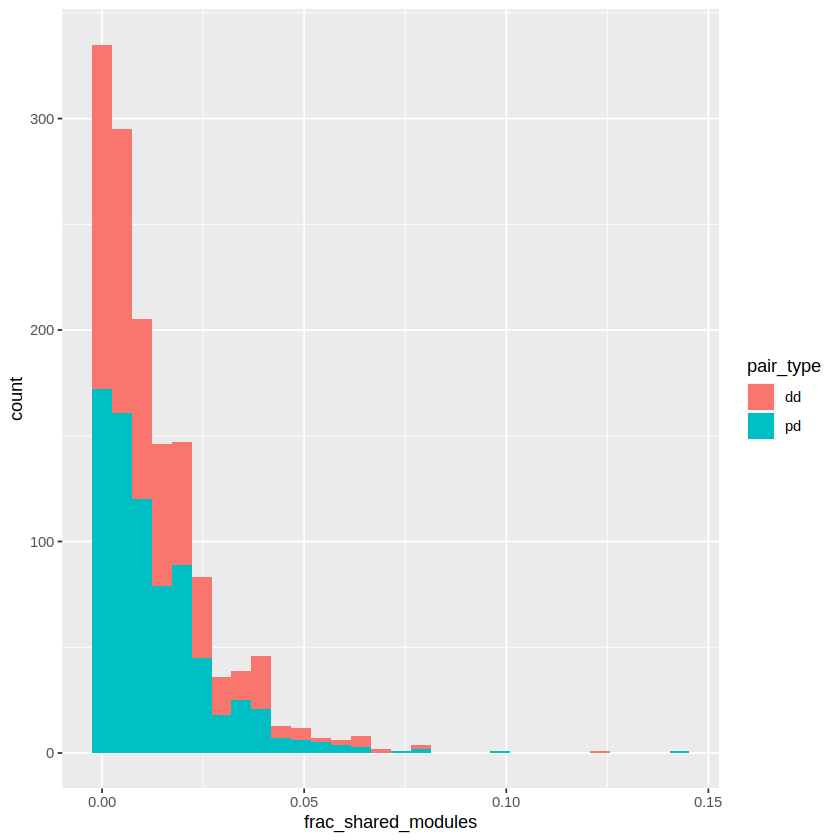

In [596]:
ggplot(pair_data, aes(x=frac_shared_modules, fill = pair_type)) + geom_histogram()

 Family: ordbeta  ( logit )
Formula:          
frac_shared_modules ~ pair_type + (1 | network_id) + (1 | phylogenetic_dist)
Data: func_data

     AIC      BIC   logLik deviance df.resid 
 -7234.0  -7197.3   3624.0  -7248.0     1381 

Random effects:

Conditional model:
 Groups            Name        Variance Std.Dev.
 network_id        (Intercept) 1.20106  1.0959  
 phylogenetic_dist (Intercept) 0.03002  0.1733  
Number of obs: 1388, groups:  network_id, 282; phylogenetic_dist, 573

Dispersion parameter for ordbeta family ():  903 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.32141    0.08173  -52.87   <2e-16 ***
pair_typepd -0.04849    0.02799   -1.73   0.0832 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


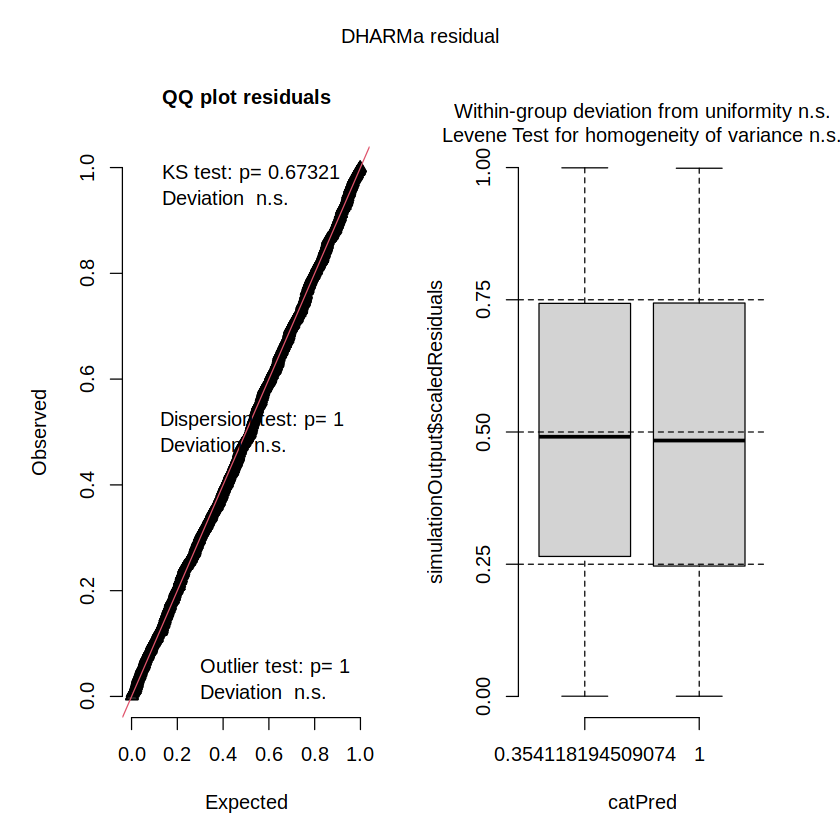

In [597]:
mod_res_df = test_pair_ploidy_level_effect("frac_shared_modules")                                         

In [598]:
mod_res_df

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Intercept,frac_shared_modules,none,NA,NA,-4.32140700,0.08173475,-52.871113,0.00000000
network_id,frac_shared_modules,random,1127.194740,4.058151e-247,NA,NA,NA,NA
pair_type,frac_shared_modules,fixed,2.999912,8.326902e-02,-0.04848566,0.02798639,-1.732473,0.08318937
phylogenetic_dist,frac_shared_modules,random,67.632552,1.969883e-16,NA,NA,NA,NA


In [599]:
full_pair_df = rbind(horn_res_df, mod_res_df)
full_pair_df["significant_by_lrt"] = full_pair_df$lrt_pvalue <= 0.05
full_pair_df["significant_by_wald_test"] = full_pair_df$z_test_pvalue <= 0.05
write.csv(full_pair_df, res_pair_path)

In [600]:
round_df(full_pair_df)

,response_variable,type,lrt_statistic,lrt_pvalue,coefficient,standard_error,z_test_statistic,z_test_pvalue,significant_by_lrt,significant_by_wald_test
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Intercept,horn_index,none,NA,NA,0.55406,0.08585,6.45397,0.00000,NA,TRUE
network_id,horn_index,random,34.44704,0.00000,NA,NA,NA,NA,TRUE,NA
pair_type,horn_index,fixed,0.80180,0.37056,0.07694,0.08585,0.89617,0.37016,FALSE,FALSE
phylogenetic_dist,horn_index,random,22.91773,0.00000,NA,NA,NA,NA,TRUE,NA
Intercept1,frac_shared_modules,none,NA,NA,-4.32141,0.08173,-52.87111,0.00000,NA,TRUE
network_id1,frac_shared_modules,random,1127.19474,0.00000,NA,NA,NA,NA,TRUE,NA
pair_type1,frac_shared_modules,fixed,2.99991,0.08327,-0.04849,0.02799,-1.73247,0.08319,FALSE,FALSE
phylogenetic_dist1,frac_shared_modules,random,67.63255,0.00000,NA,NA,NA,NA,TRUE,NA
